In [2]:
# ==============================================================================
# MISSING DATA HANDLING & TRAIN/TEST SPLIT
# ==============================================================================

# Load cleaned data
df = pd.read_csv("merged_nhanes_data_cleaned.csv")

# Drop rows with missing target variable
df = df[df['Asthmatic'].notna()]

# Identify weight columns
weight_cols = [col for col in df.columns if 'weight' in col.lower() or col.startswith('WT')]

# Drop rows with >40% missing data
row_missing_pct = df.isnull().sum(axis=1) / len(df.columns)
df = df[row_missing_pct <= 0.4]

# Fill remaining missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Asthmatic'] + weight_cols]

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col].fillna(mode_val, inplace=True)

print(f"Final dataset: {df.shape}")

# Train/test split
train, test = train_test_split(df, test_size=0.2, stratify=df['Asthmatic'], random_state=42)

print(f"Train: {train.shape}, Test: {test.shape}")

# Save
train.to_csv("train_cleaned.csv", index=False)
test.to_csv("test_cleaned.csv", index=False)

Final dataset: (12736, 31)
Train: (10188, 31), Test: (2548, 31)


In [3]:
# ==============================================================================
# SAMPLING WEIGHTS EXTRACTION
# ==============================================================================

import pandas as pd
import numpy as np
import pickle

# Load data
train = pd.read_csv("train_cleaned.csv")
test = pd.read_csv("test_cleaned.csv")

# Define feature-weight mappings
INTERVIEW_WEIGHT_FEATURES = [
    "Mother smoked when pregnant", "Child was overweight",
    "Number of people who smoke inside the house", "Used any tobacco product in last 5 days",
    "At least 100 cigarettes in life", "Age started smoking", "Currently smokes",
    "Cigarettes smoked in entire life (12-17)", "Asthmatic", "Age when first had asthma",
    "Still have asthma", "Asthma attack in past year", "Emergency care visit for asthma/past yr",
    "Taking treatment for anemia", "Vigorous work activity", "High blood pressure",
    "Shortness of breath on stairs", "Vigorous recreational activities", "Avg # alcoholic drinks/day"
]

MEC_WEIGHT_FEATURES = [
    "BMI", "Eosinophils", "White blood cell count", "Basophils",
    "Red blood cell count", "Total Cholesterol", "Urinary Total NNAL"
]

# Find weight columns
interview_weight = None
mec_weight = None

for col in train.columns:
    if 'interview weight' in col.lower():
        interview_weight = col
    if 'mec' in col.lower() and 'weight' in col.lower():
        mec_weight = col

# Create uniform weights if not found
if not interview_weight:
    train['interview_weight'] = 1.0
    test['interview_weight'] = 1.0
    interview_weight = 'interview_weight'
else:
    print(f"Interview weight: {interview_weight}")

if not mec_weight:
    train['mec_weight'] = 1.0
    test['mec_weight'] = 1.0
    mec_weight = 'mec_weight'
else:
    print(f"MEC weight: {mec_weight}")

# Check which features are present
interview_present = [f for f in INTERVIEW_WEIGHT_FEATURES if f in train.columns]
mec_present = [f for f in MEC_WEIGHT_FEATURES if f in train.columns]

# Save weight info
weight_info = {
    'interview_weight': interview_weight,
    'mec_weight': mec_weight,
    'interview_features': interview_present,
    'mec_features': mec_present
}

with open("weight_info.pkl", "wb") as f:
    pickle.dump(weight_info, f)

# Extract and save weight arrays
np.save("train_interview_weights.npy", train[interview_weight].values)
np.save("test_interview_weights.npy", test[interview_weight].values)
np.save("train_mec_weights.npy", train[mec_weight].values)
np.save("test_mec_weights.npy", test[mec_weight].values)

print(f"Interview features: {len(interview_present)}/{len(INTERVIEW_WEIGHT_FEATURES)}")
print(f"MEC features: {len(mec_present)}/{len(MEC_WEIGHT_FEATURES)}")

Interview weight: Full sample 2 year interview weight
MEC weight: Full sample 2 year MEC exam weight
Interview features: 19/19
MEC features: 7/7


In [4]:
# ==============================================================================
# FEATURE SELECTION WITH WEIGHTED STATISTICAL TESTS
# ==============================================================================
# HOW WEIGHTS ARE USED:
# 1. Each feature is matched to its appropriate weight type:
#    - Interview features → Interview weights
#    - MEC features → MEC weights
# 2. Statistical tests (correlation, chi-square) use these weights to:
#    - Give more importance to observations from underrepresented groups
#    - Account for NHANES complex survey design
#    - Calculate effective sample sizes (not just raw counts)
# ==============================================================================

from scipy.stats import chi2_contingency, t
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load data and weights
train = pd.read_csv("train_cleaned.csv")

with open("weight_info.pkl", "rb") as f:
    weight_info = pickle.load(f)

interview_weight = weight_info['interview_weight']
mec_weight = weight_info['mec_weight']
interview_features = weight_info['interview_features']
mec_features = weight_info['mec_features']

protected_cols = [interview_weight, mec_weight, 'Asthmatic']
all_features = [col for col in train.columns if col not in protected_cols]

print(f"Features to evaluate: {len(all_features)}")

# ==============================================================================
# WEIGHT ASSIGNMENT FUNCTION
# ==============================================================================

def get_weight_for_feature(feature_name):
    """Match each feature to its appropriate weight"""
    if feature_name in mec_features:
        return mec_weight
    elif feature_name in interview_features:
        return interview_weight
    else:
        return interview_weight  # Default

# ==============================================================================
# WEIGHTED STATISTICAL TESTS
# ==============================================================================

def weighted_pearson(x, y, weights):
    """Weighted Pearson correlation with effective sample size"""
    valid_mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(weights))
    x, y, w = x[valid_mask], y[valid_mask], weights[valid_mask]
    
    if len(x) < 10:
        return np.nan, 1.0, 0
    
    # Normalize weights
    w = w / w.sum()
    
    # Weighted correlation
    x_mean = np.sum(w * x)
    y_mean = np.sum(w * y)
    cov = np.sum(w * (x - x_mean) * (y - y_mean))
    x_std = np.sqrt(np.sum(w * (x - x_mean)**2))
    y_std = np.sqrt(np.sum(w * (y - y_mean)**2))
    
    if x_std > 0 and y_std > 0:
        corr = cov / (x_std * y_std)
    else:
        return np.nan, 1.0, 0
    
    # Effective sample size (Kish's approximation)
    n_eff = (w.sum()**2) / np.sum(w**2)
    
    # P-value
    if abs(corr) < 0.9999:
        t_stat = corr * np.sqrt(n_eff - 2) / np.sqrt(1 - corr**2)
        p_value = 2 * (1 - t.cdf(abs(t_stat), n_eff - 2))
    else:
        p_value = 0.0
    
    return corr, p_value, n_eff

def weighted_chi_square(x, y, weights):
    """Weighted chi-square test with Cramér's V"""
    df = pd.DataFrame({'x': x, 'y': y, 'w': weights}).dropna()
    
    if len(df) < 10:
        return np.nan, 1.0, 0
    
    # Weighted contingency table
    contingency = df.groupby(['x', 'y'])['w'].sum().unstack(fill_value=0)
    
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        return np.nan, 1.0, 0
    
    try:
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        n = contingency.sum().sum()
        min_dim = min(contingency.shape[0], contingency.shape[1]) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        # Effective sample size
        w = df['w'].values
        n_eff = (w.sum()**2) / (w**2).sum()
        
        return cramers_v, p_value, n_eff
    except:
        return np.nan, 1.0, 0

# ==============================================================================
# CATEGORIZE FEATURES
# ==============================================================================

continuous_features = []
binary_features = []
categorical_features = []

for col in all_features:
    n_unique = train[col].dropna().nunique()
    
    if n_unique == 2:
        binary_features.append(col)
    elif train[col].dtype in ['int64', 'float64'] and n_unique > 10:
        continuous_features.append(col)
    else:
        categorical_features.append(col)

print(f"Continuous: {len(continuous_features)}, Binary: {len(binary_features)}, Categorical: {len(categorical_features)}")

# ==============================================================================
# RUN WEIGHTED TESTS
# ==============================================================================

all_results = []

# Test continuous features
for col in continuous_features:
    weight_col = get_weight_for_feature(col)
    valid_mask = train[col].notna() & train['Asthmatic'].notna() & train[weight_col].notna()
    
    if valid_mask.sum() < 10:
        continue
    
    x = train.loc[valid_mask, col].values
    y = train.loc[valid_mask, 'Asthmatic'].values
    w = train.loc[valid_mask, weight_col].values
    
    corr, p_value, n_eff = weighted_pearson(x, y, w)
    
    if not np.isnan(corr):
        all_results.append({
            'feature': col,
            'correlation': abs(corr),
            'p_value': p_value,
            'n_effective': int(n_eff),
            'test': 'Weighted Pearson',
            'weight_used': 'MEC' if weight_col == mec_weight else 'Interview'
        })

# Test binary features
for col in binary_features:
    weight_col = get_weight_for_feature(col)
    valid_mask = train[col].notna() & train['Asthmatic'].notna() & train[weight_col].notna()
    
    if valid_mask.sum() < 10:
        continue
    
    x = train.loc[valid_mask, col].values
    y = train.loc[valid_mask, 'Asthmatic'].values
    w = train.loc[valid_mask, weight_col].values
    
    cramers_v, p_value, n_eff = weighted_chi_square(x, y, w)
    
    if not np.isnan(cramers_v):
        all_results.append({
            'feature': col,
            'correlation': cramers_v,
            'p_value': p_value,
            'n_effective': int(n_eff),
            'test': 'Weighted Chi-Square',
            'weight_used': 'MEC' if weight_col == mec_weight else 'Interview'
        })

# Test categorical features
for col in categorical_features:
    if train[col].nunique() > 20:
        continue
    
    weight_col = get_weight_for_feature(col)
    valid_mask = train[col].notna() & train['Asthmatic'].notna() & train[weight_col].notna()
    
    if valid_mask.sum() < 10:
        continue
    
    x = train.loc[valid_mask, col].values
    y = train.loc[valid_mask, 'Asthmatic'].values
    w = train.loc[valid_mask, weight_col].values
    
    cramers_v, p_value, n_eff = weighted_chi_square(x, y, w)
    
    if not np.isnan(cramers_v):
        all_results.append({
            'feature': col,
            'correlation': cramers_v,
            'p_value': p_value,
            'n_effective': int(n_eff),
            'test': 'Weighted Chi-Square',
            'weight_used': 'MEC' if weight_col == mec_weight else 'Interview'
        })

# ==============================================================================
# SELECT FEATURES
# ==============================================================================

all_results_df = pd.DataFrame(all_results).sort_values('correlation', ascending=False)

# Selection criteria
selected_df = all_results_df[
    (all_results_df['correlation'] > 0.05) & 
    (all_results_df['p_value'] < 0.05)
]

print(f"\nSelected features: {len(selected_df)}/{len(all_results_df)}")
print(f"  Interview weighted: {(selected_df['weight_used'] == 'Interview').sum()}")
print(f"  MEC weighted: {(selected_df['weight_used'] == 'MEC').sum()}")

# Display top features
print(f"\nTop 15 features:")
for i, row in selected_df.head(15).iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
    print(f"  {row['feature'][:40]:40s}: {row['correlation']:.4f} {sig} [{row['weight_used']}]")

# ==============================================================================
# SAVE RESULTS
# ==============================================================================

selected_features = selected_df['feature'].tolist()

with open("selected_features.txt", "w") as f:
    for feature in selected_features:
        f.write(feature + "\n")

all_results_df.to_csv("feature_selection_results.csv", index=False)
selected_df.to_csv("selected_features_stats.csv", index=False)

Features to evaluate: 28
Continuous: 11, Binary: 14, Categorical: 3

Selected features: 10/28
  Interview weighted: 9
  MEC weighted: 1

Top 15 features:
  Still have asthma                       : 0.5787 *** [Interview]
  Asthma attack in past year              : 0.5054 *** [Interview]
  Age when first had asthma               : 0.3656 *** [Interview]
  Emergency care visit for asthma/past yr : 0.2708 *** [Interview]
  Eosinophils                             : 0.1146 *** [MEC]
  Age                                     : 0.1086 *** [Interview]
  Child was overweight                    : 0.0868 *** [Interview]
  Shortness of breath on stairs           : 0.0710 *** [Interview]
  Mother smoked when pregnant             : 0.0573 *** [Interview]
  Gender                                  : 0.0535 *** [Interview]


In [5]:
# ============================================================================
# PREPROCESSING FOR MODELS
# ============================================================================

# ============================================================================
# LOAD DATA
# ============================================================================

train = pd.read_csv("train_cleaned.csv")
test = pd.read_csv("test_cleaned.csv")

with open("weight_info.pkl", "rb") as f:
    weight_info = pickle.load(f)

with open("selected_features.txt", "r") as f:
    selected_features = [line.strip() for line in f.readlines()]

print(f"Loaded: {len(selected_features)} selected features")

# ============================================================================
# REMOVE DATA LEAKAGE FEATURES
# ============================================================================

LEAKAGE_FEATURES = [
    "Still have asthma",
    "Asthma attack in past year",
    "Emergency care visit for asthma/past yr",
    "Age when first had asthma", "Age"
]

clean_features = [f for f in selected_features if f not in LEAKAGE_FEATURES]
removed = len(selected_features) - len(clean_features)

print(f"Removed {removed} leakage features -> {len(clean_features)} features remaining")

# ============================================================================
# CLASSIFY AND ENCODE FEATURES
# ============================================================================

continuous_features = []
binary_features = []
categorical_features = []

for col in clean_features:
    n_unique = train[col].dropna().nunique()
    
    if n_unique == 2:
        binary_features.append(col)
    elif train[col].dtype in ['int64', 'float64'] and n_unique > 10:
        continuous_features.append(col)
    else:
        categorical_features.append(col)

print(f"Feature types: {len(continuous_features)} continuous, {len(binary_features)} binary, {len(categorical_features)} categorical")

# Encode categorical features
train_encoded = train.copy()
test_encoded = test.copy()
encoding_info = {}

for col in categorical_features:
    n_categories = train[col].nunique()
    
    if n_categories <= 5:
        # One-hot encoding
        train_dummies = pd.get_dummies(train[col], prefix=col, drop_first=True)
        test_dummies = pd.get_dummies(test[col], prefix=col, drop_first=True)
        
        for dummy_col in train_dummies.columns:
            if dummy_col not in test_dummies.columns:
                test_dummies[dummy_col] = 0
        
        train_encoded = pd.concat([train_encoded, train_dummies], axis=1)
        test_encoded = pd.concat([test_encoded, test_dummies], axis=1)
        
        clean_features.remove(col)
        clean_features.extend(train_dummies.columns.tolist())
        
        encoding_info[col] = {'method': 'one-hot', 'new_columns': train_dummies.columns.tolist()}
    else:
        # Ordinal encoding
        categories = sorted(train[col].dropna().unique())
        mapping = {cat: i for i, cat in enumerate(categories)}
        
        train_encoded[col] = train[col].map(mapping)
        test_encoded[col] = test[col].map(mapping)
        
        if test_encoded[col].isna().any():
            most_common = train_encoded[col].mode()[0]
            test_encoded[col] = test_encoded[col].fillna(most_common)
        
        encoding_info[col] = {'method': 'ordinal', 'mapping': mapping}

if categorical_features:
    print(f"Encoded {len(categorical_features)} categorical features")

# ============================================================================
# PREPARE FINAL DATASETS
# ============================================================================

X_train = train_encoded[clean_features].copy()
X_test = test_encoded[clean_features].copy()
y_train = train_encoded['Asthmatic'].copy()
y_test = test_encoded['Asthmatic'].copy()

# Handle missing values
train_missing = X_train.isnull().sum().sum()
test_missing = X_test.isnull().sum().sum()

if train_missing > 0 or test_missing > 0:
    for col in X_train.columns:
        if X_train[col].isnull().any():
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)
    print(f"Imputed {train_missing + test_missing} missing values")

# ============================================================================
# DETERMINE SAMPLE WEIGHTS
# ============================================================================

mec_features = weight_info['mec_features']
has_mec = any(f in mec_features for f in clean_features)

if has_mec:
    train_weights = train_encoded[weight_info['mec_weight']].values
    test_weights = test_encoded[weight_info['mec_weight']].values
    weight_type = 'mec'
else:
    train_weights = train_encoded[weight_info['interview_weight']].values
    test_weights = test_encoded[weight_info['interview_weight']].values
    weight_type = 'interview'

print(f"Using {weight_type} weights")

# ============================================================================
# SAVE PROCESSED DATA
# ============================================================================

X_train.to_csv("X_train_processed.csv", index=False)
X_test.to_csv("X_test_processed.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

np.save("train_sample_weights.npy", train_weights)
np.save("test_sample_weights.npy", test_weights)

final_info = {
    'features': clean_features,
    'continuous_features': continuous_features,
    'binary_features': binary_features,
    'categorical_features': categorical_features,
    'encoding_info': encoding_info,
    'removed_leakage': removed,
    'weight_type_used': weight_type
}

with open("processed_data_info.pkl", "wb") as f:
    pickle.dump(final_info, f)

# ============================================================================
# SUMMARY
# ============================================================================

print(f"Final features: {len(clean_features)}")
print(f"Train asthma rate: {y_train.mean():.2%}")
print(f"Test asthma rate: {y_test.mean():.2%}")

Loaded: 10 selected features
Removed 5 leakage features -> 5 features remaining
Feature types: 1 continuous, 4 binary, 0 categorical
Imputed 11284 missing values
Using mec weights
Final features: 5
Train asthma rate: 18.69%
Test asthma rate: 18.68%


In [6]:
"""
STEP 4: RISK STRATIFICATION WITH FEATURE ENGINEERING (CONDENSED)
"""

import pandas as pd
import numpy as np
import pickle
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import joblib

warnings.filterwarnings('ignore')

# ============================================================================
# LOAD DATA
# ============================================================================

X_train = pd.read_csv("X_train_processed.csv")
X_test = pd.read_csv("X_test_processed.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()
train_weights = np.load("train_sample_weights.npy")
test_weights = np.load("test_sample_weights.npy")

with open("processed_data_info.pkl", "rb") as f:
    data_info = pickle.load(f)

imbalance_ratio = (1-y_train).sum() / y_train.sum()
print(f"Data: {X_train.shape[0]} train, {X_test.shape[0]} test")
print(f"Imbalance: {imbalance_ratio:.2f}:1 | Train asthma: {y_train.mean():.2%} | Test asthma: {y_test.mean():.2%}\n")

# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

X_train_fe = X_train.copy()
X_test_fe = X_test.copy()
original_count = X_train_fe.shape[1]

def safe_add(train_df, test_df, name, train_vals, test_vals):
    if name not in train_df.columns:
        train_df[name] = train_vals
        test_df[name] = test_vals
        return True
    return False

added = 0

# Domain interactions
if 'Age' in X_train_fe.columns and 'Currently smokes' in X_train_fe.columns:
    added += safe_add(X_train_fe, X_test_fe, 'age_x_smoking',
                     X_train_fe['Age'] * X_train_fe['Currently smokes'],
                     X_test_fe['Age'] * X_test_fe['Currently smokes'])

if 'BMI' in X_train_fe.columns and 'Age' in X_train_fe.columns:
    added += safe_add(X_train_fe, X_test_fe, 'bmi_x_age',
                     X_train_fe['BMI'] * X_train_fe['Age'],
                     X_test_fe['BMI'] * X_test_fe['Age'])

if 'Eosinophils' in X_train_fe.columns and 'White blood cell count' in X_train_fe.columns:
    added += safe_add(X_train_fe, X_test_fe, 'eosinophils_x_wbc',
                     X_train_fe['Eosinophils'] * X_train_fe['White blood cell count'],
                     X_test_fe['Eosinophils'] * X_test_fe['White blood cell count'])

if 'Gender' in X_train_fe.columns and 'Currently smokes' in X_train_fe.columns:
    added += safe_add(X_train_fe, X_test_fe, 'gender_x_smoking',
                     X_train_fe['Gender'] * X_train_fe['Currently smokes'],
                     X_test_fe['Gender'] * X_test_fe['Currently smokes'])

# BMI categories
if 'BMI' in X_train_fe.columns:
    added += safe_add(X_train_fe, X_test_fe, 'bmi_underweight',
                     (X_train_fe['BMI'] < 18.5).astype(int),
                     (X_test_fe['BMI'] < 18.5).astype(int))
    added += safe_add(X_train_fe, X_test_fe, 'bmi_overweight',
                     ((X_train_fe['BMI'] >= 25) & (X_train_fe['BMI'] < 30)).astype(int),
                     ((X_test_fe['BMI'] >= 25) & (X_test_fe['BMI'] < 30)).astype(int))
    added += safe_add(X_train_fe, X_test_fe, 'bmi_obese',
                     (X_train_fe['BMI'] >= 30).astype(int),
                     (X_test_fe['BMI'] >= 30).astype(int))

# Age groups
if 'Age' in X_train_fe.columns:
    added += safe_add(X_train_fe, X_test_fe, 'age_child',
                     (X_train_fe['Age'] < 18).astype(int),
                     (X_test_fe['Age'] < 18).astype(int))
    added += safe_add(X_train_fe, X_test_fe, 'age_senior',
                     (X_train_fe['Age'] >= 65).astype(int),
                     (X_test_fe['Age'] >= 65).astype(int))

# Polynomial features
continuous_cols = [col for col in ['Age', 'BMI', 'Eosinophils', 'White blood cell count'] 
                   if col in X_train_fe.columns]

if continuous_cols:
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_fe[continuous_cols])
    X_test_poly = poly.transform(X_test_fe[continuous_cols])
    
    poly_names = poly.get_feature_names_out(continuous_cols)
    new_poly_names = [name for name in poly_names if name not in continuous_cols]
    
    X_train_poly_df = pd.DataFrame(X_train_poly[:, len(continuous_cols):],
                                    columns=new_poly_names, index=X_train_fe.index)
    X_test_poly_df = pd.DataFrame(X_test_poly[:, len(continuous_cols):],
                                   columns=new_poly_names, index=X_test_fe.index)
    
    X_train_fe = pd.concat([X_train_fe, X_train_poly_df], axis=1)
    X_test_fe = pd.concat([X_test_fe, X_test_poly_df], axis=1)

print(f"Feature Engineering: {original_count} → {X_train_fe.shape[1]} ({added} domain + {len(new_poly_names)} polynomial)\n")

X_train_fe = X_train_fe.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_fe = X_test_fe.replace([np.inf, -np.inf], np.nan).fillna(0)

# ============================================================================
# CLASS BALANCING & STANDARDIZATION
# ============================================================================

class_weights = compute_sample_weight('balanced', y_train)
train_weights_balanced = train_weights * class_weights
train_weights_balanced = train_weights_balanced * (train_weights.sum() / train_weights_balanced.sum())

print(f"Class Weighting: minority {class_weights[y_train==1].mean():.2f}x, majority {class_weights[y_train==0].mean():.2f}x\n")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fe)
X_test_scaled = scaler.transform(X_test_fe)

# ============================================================================
# MODEL TRAINING
# ============================================================================

print("Training models...\n")

# Logistic Regression
best_lr_auc = 0
for C in [0.01, 0.1, 1.0, 10.0]:
    lr = LogisticRegression(C=C, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train, sample_weight=train_weights_balanced)
    auc = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1], sample_weight=test_weights)
    if auc > best_lr_auc:
        best_lr_auc, lr_model = auc, lr

lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
best_xgb_auc = 0
for n_est, depth, lr_rate in [(100, 3, 0.1), (100, 5, 0.1), (200, 5, 0.05), (200, 7, 0.05)]:
    xgb_temp = xgb.XGBClassifier(n_estimators=n_est, max_depth=depth, learning_rate=lr_rate,
                                  subsample=0.8, colsample_bytree=0.8, gamma=1,
                                  scale_pos_weight=scale_pos_weight, random_state=42,
                                  eval_metric='auc', use_label_encoder=False)
    xgb_temp.fit(X_train_fe, y_train, sample_weight=train_weights_balanced, verbose=False)
    auc = roc_auc_score(y_test, xgb_temp.predict_proba(X_test_fe)[:, 1], sample_weight=test_weights)
    if auc > best_xgb_auc:
        best_xgb_auc, xgb_model = auc, xgb_temp

xgb_pred_proba = xgb_model.predict_proba(X_test_fe)[:, 1]

# Random Forest
best_rf_auc = 0
for n_est, depth, min_split in [(200, 10, 20), (200, 15, 15), (300, 12, 20), (200, None, 15)]:
    rf_temp = RandomForestClassifier(n_estimators=n_est, max_depth=depth, min_samples_split=min_split,
                                      min_samples_leaf=10, max_features='sqrt', random_state=42, n_jobs=-1)
    rf_temp.fit(X_train_fe, y_train, sample_weight=train_weights_balanced)
    auc = roc_auc_score(y_test, rf_temp.predict_proba(X_test_fe)[:, 1], sample_weight=test_weights)
    if auc > best_rf_auc:
        best_rf_auc, rf_model = auc, rf_temp

rf_pred_proba = rf_model.predict_proba(X_test_fe)[:, 1]

# Extra Trees
best_et_auc = 0
for n_est, depth, min_split in [(150, 10, 15), (200, 12, 15), (200, 15, 15), (300, 12, 20), (200, None, 15)]:
    et_temp = ExtraTreesClassifier(n_estimators=n_est, max_depth=depth, min_samples_split=min_split,
                                     min_samples_leaf=8, max_features='sqrt', bootstrap=True, 
                                     random_state=42, n_jobs=-1)
    et_temp.fit(X_train_fe, y_train, sample_weight=train_weights_balanced)
    auc = roc_auc_score(y_test, et_temp.predict_proba(X_test_fe)[:, 1], sample_weight=test_weights)
    if auc > best_et_auc:
        best_et_auc, et_model = auc, et_temp

et_pred_proba = et_model.predict_proba(X_test_fe)[:, 1]

# KNN
knn_model = KNeighborsClassifier(n_neighbors=15, weights='distance', algorithm='auto', n_jobs=-1)
knn_model.fit(X_train_scaled, y_train)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
knn_auc = roc_auc_score(y_test, knn_pred_proba, sample_weight=test_weights)

# Ensemble
best_ens_auc = 0
for w in [(0.4, 0.3, 0.3, 0.0), (0.3, 0.3, 0.3, 0.1), (0.35, 0.25, 0.25, 0.15), 
          (0.5, 0.2, 0.2, 0.1), (0.25, 0.25, 0.25, 0.25)]:
    ens_proba = w[0]*lr_pred_proba + w[1]*xgb_pred_proba + w[2]*rf_pred_proba + w[3]*et_pred_proba
    auc = roc_auc_score(y_test, ens_proba, sample_weight=test_weights)
    if auc > best_ens_auc:
        best_ens_auc, best_ens_weights, ensemble_proba = auc, w, ens_proba

# ============================================================================
# MODEL COMPARISON
# ============================================================================

def calc_metrics(y_true, y_proba, weights):
    y_pred = (y_proba >= 0.5).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, y_pred, sample_weight=weights),
        'Precision': precision_score(y_true, y_pred, sample_weight=weights, zero_division=0),
        'Recall': recall_score(y_true, y_pred, sample_weight=weights, zero_division=0),
        'F1': f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    }

models_data = {
    'Logistic Regression': (best_lr_auc, lr_pred_proba),
    'XGBoost': (best_xgb_auc, xgb_pred_proba),
    'Random Forest': (best_rf_auc, rf_pred_proba),
    'ExtraTrees': (best_et_auc, et_pred_proba),
    'Ensemble': (best_ens_auc, ensemble_proba),
    'KNN': (knn_auc, knn_pred_proba)
}

comparison_data = []
for name, (auc, proba) in models_data.items():
    metrics = calc_metrics(y_test, proba, test_weights)
    comparison_data.append({
        'Model': name, 'AUC': auc, 'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'], 'Recall': metrics['Recall'], 'F1': metrics['F1']
    })

comparison = pd.DataFrame(comparison_data)
comparison['Composite'] = 0.6 * comparison['AUC'] + 0.4 * comparison['F1']

print("="*95)
print("MODEL COMPARISON (Selection: 0.6×AUC + 0.4×F1)")
print("="*95)
print(comparison.sort_values('Composite', ascending=False).to_string(index=False))

best_row = comparison.loc[comparison['Composite'].idxmax()]
best_model_name = best_row['Model']

print(f"\n✓ Best: {best_model_name} | AUC: {best_row['AUC']:.4f} | F1: {best_row['F1']:.4f} | Composite: {best_row['Composite']:.4f}\n")

model_to_proba = {
    'Logistic Regression': lr_pred_proba, 'XGBoost': xgb_pred_proba,
    'Random Forest': rf_pred_proba, 'ExtraTrees': et_pred_proba,
    'Ensemble': ensemble_proba, 'KNN': knn_pred_proba
}
best_pred_proba = model_to_proba[best_model_name]

# ============================================================================
# RISK STRATIFICATION
# ============================================================================

low_th = np.percentile(best_pred_proba, 20)
high_th = np.percentile(best_pred_proba, 60)
risk_tiers = np.where(best_pred_proba < low_th, 'Low',
                     np.where(best_pred_proba < high_th, 'Moderate', 'High'))

print("="*95)
print(f"RISK STRATIFICATION ({best_model_name})")
print("="*95)
print(f"Thresholds: Low < {low_th:.3f} < Moderate < {high_th:.3f} < High\n")

for tier in ['Low', 'Moderate', 'High']:
    mask = risk_tiers == tier
    count = mask.sum()
    pct = count / len(risk_tiers) * 100
    asthma_count = y_test[mask].sum()
    asthma_rate = y_test[mask].mean()
    print(f"{tier:10s}: {count:4d} samples ({pct:5.1f}%) | {asthma_count:3.0f} asthma cases ({asthma_rate:6.2%})")

low_rate = y_test[risk_tiers == 'Low'].mean()
high_rate = y_test[risk_tiers == 'High'].mean()
risk_ratio = high_rate / low_rate if low_rate > 0 else float('inf')
print(f"\nRisk Ratio (High/Low): {risk_ratio:.2f}x\n")

# ============================================================================
# SAVE RESULTS
# ============================================================================

joblib.dump(lr_model, 'logistic_regression_tuned.pkl')
joblib.dump(xgb_model, 'xgboost_tuned.pkl')
joblib.dump(rf_model, 'random_forest_tuned.pkl')
joblib.dump(et_model, 'extratrees_tuned.pkl')
joblib.dump(knn_model, 'knn_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

with open('ensemble_info.pkl', 'wb') as f:
    pickle.dump({'weights': best_ens_weights, 'model_order': ['LR', 'XGB', 'RF', 'ET'], 
                 'best_auc': best_ens_auc}, f)

with open('best_model_info.pkl', 'wb') as f:
    pickle.dump({'best_model_name': best_model_name, 'best_auc': best_row['AUC'],
                 'best_f1': best_row['F1'], 'best_composite': best_row['Composite'],
                 'selection_method': 'composite_0.6auc_0.4f1',
                 'class_imbalance_strategy': 'class_weighting',
                 'imbalance_ratio': imbalance_ratio}, f)

X_train_fe.to_csv('X_train_engineered.csv', index=False)
X_test_fe.to_csv('X_test_engineered.csv', index=False)

results_df = pd.DataFrame({
    'y_true': y_test, 'lr_proba': lr_pred_proba, 'xgb_proba': xgb_pred_proba,
    'rf_proba': rf_pred_proba, 'et_proba': et_pred_proba, 'ensemble_proba': ensemble_proba,
    'knn_proba': knn_pred_proba, 'best_model_proba': best_pred_proba,
    'risk_tier': risk_tiers, 'test_weight': test_weights
})
results_df.to_csv('all_model_predictions.csv', index=False)
comparison.to_csv('model_comparison_final.csv', index=False)

# Feature importances
for model, name in [(lr_model, 'lr'), (xgb_model, 'xgb'), (rf_model, 'rf'), (et_model, 'et')]:
    if name == 'lr':
        imp = pd.DataFrame({'feature': X_train_fe.columns, 'coefficient': model.coef_[0],
                           'abs_coefficient': np.abs(model.coef_[0])}).sort_values('abs_coefficient', ascending=False)
    else:
        imp = pd.DataFrame({'feature': X_train_fe.columns, 
                           'importance': model.feature_importances_}).sort_values('importance', ascending=False)
    imp.to_csv(f'{name}_feature_importance.csv', index=False)

print("✓ All models and results saved!")

Data: 10188 train, 2548 test
Imbalance: 4.35:1 | Train asthma: 18.69% | Test asthma: 18.68%

Feature Engineering: 5 → 5 (0 domain + 0 polynomial)

Class Weighting: minority 2.68x, majority 0.61x

Training models...

MODEL COMPARISON (Selection: 0.6×AUC + 0.4×F1)
              Model      AUC  Accuracy  Precision   Recall       F1  Composite
Logistic Regression 0.630641  0.692863   0.265844 0.418342 0.325098   0.508424
           Ensemble 0.633196  0.340508   0.195668 0.877498 0.319984   0.507911
      Random Forest 0.630504  0.744298   0.299459 0.333050 0.315362   0.504448
         ExtraTrees 0.623395  0.735599   0.291379 0.345872 0.316296   0.500555
            XGBoost 0.628957  0.177623   0.176966 1.000000 0.300716   0.497660
                KNN 0.531881  0.818641   0.376014 0.038884 0.070480   0.347321

✓ Best: Logistic Regression | AUC: 0.6306 | F1: 0.3251 | Composite: 0.5084

RISK STRATIFICATION (Logistic Regression)
Thresholds: Low < 0.400 < Moderate < 0.487 < High

Low       :  4

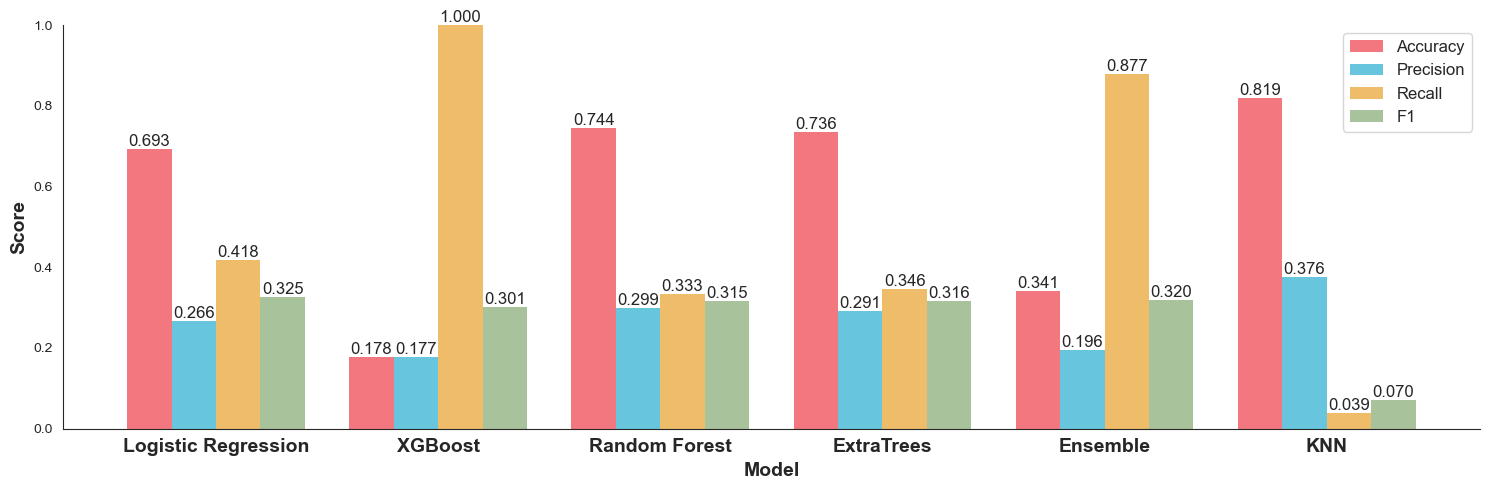

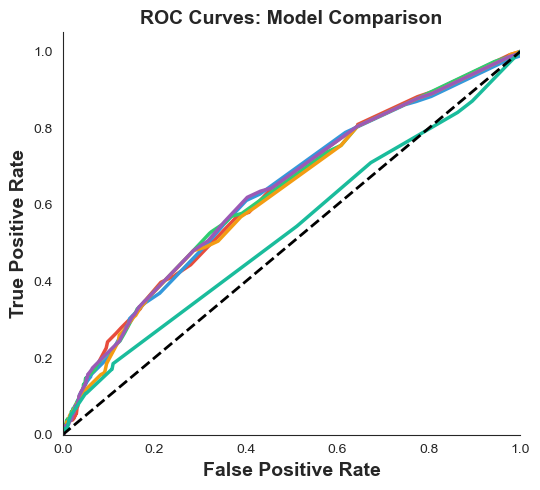

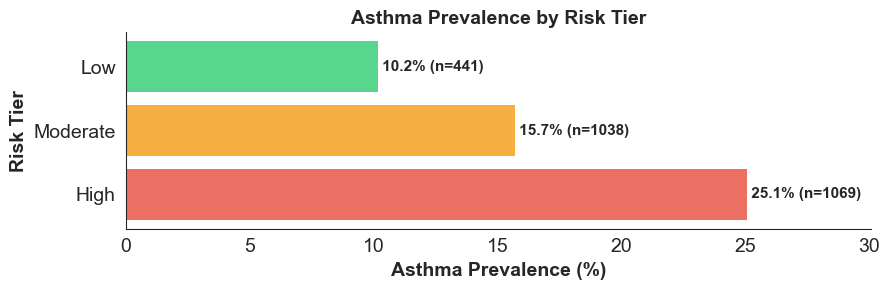


VISUALIZATION SUMMARY

Best Model: Logistic Regression
  AUC: 0.6306
  Accuracy: 0.6929
  F1 Score: 0.3251

Risk Stratification:
  Low     :  441 samples,  45 cases ( 10.2%)
  Moderate: 1038 samples, 163 cases ( 15.7%)
  High    : 1069 samples, 268 cases ( 25.1%)
  Risk Ratio (High/Low): 2.46x

All visualizations generated successfully!


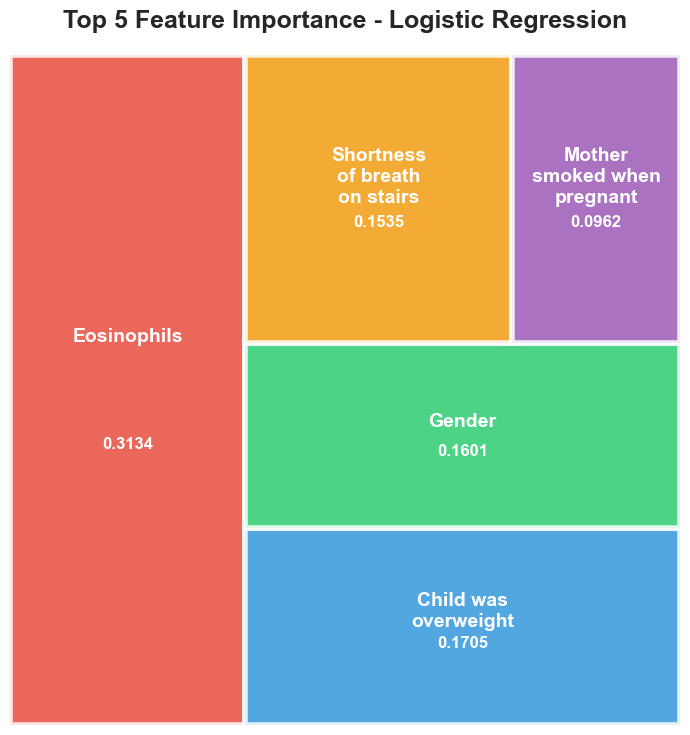


✓ Treemap saved: treemap_top_features.png

Top 5 Features:
  1. Eosinophils: 0.3134
  2. Child was overweight: 0.1705
  3. Gender: 0.1601
  4. Shortness of breath on stairs: 0.1535
  5. Mother smoked when pregnant: 0.0962


In [7]:
"""
VISUALIZATIONS FOR RISK STRATIFICATION RESULTS
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import warnings

warnings.filterwarnings('ignore')
sns.set_style("white")
plt.rcParams['figure.dpi'] = 100

# ============================================================================
# LOAD DATA
# ============================================================================

# Load results
comparison = pd.read_csv('model_comparison_final.csv')
results_df = pd.read_csv('all_model_predictions.csv')
y_test = results_df['y_true'].values
test_weights = results_df['test_weight'].values

# Load feature importance for best model
try:
    feature_imp = pd.read_csv('xgb_feature_importance.csv')
    best_model_name = 'XGBoost'
except:
    # Fallback to any available
    for model_prefix in ['xgb', 'rf', 'et', 'lr']:
        try:
            feature_imp = pd.read_csv(f'{model_prefix}_feature_importance.csv')
            best_model_name = {'xgb': 'XGBoost', 'rf': 'Random Forest', 
                              'et': 'ExtraTrees', 'lr': 'Logistic Regression'}[model_prefix]
            break
        except:
            continue

# ============================================================================
# 1. MODEL COMPARISON BAR CHART
# ============================================================================

fig, ax = plt.subplots(figsize=(15, 5))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(comparison))
width = 0.2

colors = ['#f0555e', '#41b8d5', '#ebac45', '#92b382']

for i, metric in enumerate(metrics):
    offset = width * (i - 1.5)
    bars = ax.bar(x + offset, comparison[metric], width, 
                   label=metric, color=colors[i], alpha=0.8, edgecolor='none')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'], rotation=0, ha='center', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', ncol=1, fontsize=12, frameon=True)
ax.set_ylim([0, 1.0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 2. ROC CURVES FOR ALL MODELS
# ============================================================================

fig, ax = plt.subplots(figsize=(5.5, 5))

model_probas = {
    'Logistic Regression': results_df['lr_proba'].values,
    'XGBoost': results_df['xgb_proba'].values,
    'Random Forest': results_df['rf_proba'].values,
    'ExtraTrees': results_df['et_proba'].values,
    'Ensemble': results_df['ensemble_proba'].values,
    'KNN': results_df['knn_proba'].values
}

colors_roc = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for (name, proba), color in zip(model_probas.items(), colors_roc):
    fpr, tpr, _ = roc_curve(y_test, proba, sample_weight=test_weights)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2.5, 
            label=f'{name} (AUC = {roc_auc:.3f})')

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Baseline (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
#ax.legend(loc='lower right', ncol=1, fontsize=12, frameon=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 3. RISK STRATIFICATION HORIZONTAL BAR CHART
# ============================================================================

risk_tiers = results_df['risk_tier'].values

# Calculate statistics for each tier
tier_stats = []
for tier in ['Low', 'Moderate', 'High']:
    mask = risk_tiers == tier
    total_count = mask.sum()
    asthma_count = y_test[mask].sum()
    asthma_rate = y_test[mask].mean() * 100
    tier_stats.append({
        'Risk Tier': tier,
        'Total Samples': total_count,
        'Asthma Cases': int(asthma_count),
        'Asthma Rate (%)': asthma_rate
    })

tier_df = pd.DataFrame(tier_stats)

# Create single plot for asthma prevalence
fig, ax = plt.subplots(figsize=(9, 3))

y_pos = np.arange(len(tier_df))
colors_risk = ['#2ecc71', '#f39c12', '#e74c3c']

bars = ax.barh(y_pos, tier_df['Asthma Rate (%)'], color=colors_risk, alpha=0.8, edgecolor='none')
ax.set_ylabel('Risk Tier', fontsize=14, fontweight='bold')
ax.set_xlabel('Asthma Prevalence (%)', fontsize=14, fontweight='bold')
ax.set_title('Asthma Prevalence by Risk Tier', fontsize=14, fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(tier_df['Risk Tier'], fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.invert_yaxis()
ax.set_xlim([0, max(tier_df['Asthma Rate (%)']) * 1.2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels with sample count
for bar, rate, samples in zip(bars, tier_df['Asthma Rate (%)'], tier_df['Total Samples']):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
             f' {rate:.1f}% (n={samples})', ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('risk_stratification_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate risk ratio
low_rate = tier_df[tier_df['Risk Tier'] == 'Low']['Asthma Rate (%)'].values[0]
high_rate = tier_df[tier_df['Risk Tier'] == 'High']['Asthma Rate (%)'].values[0]
risk_ratio = high_rate / low_rate if low_rate > 0 else float('inf')

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZATION SUMMARY")
print("="*70)

# Best model info
best_model_row = comparison.loc[comparison['Composite'].idxmax()]
print(f"\nBest Model: {best_model_row['Model']}")
print(f"  AUC: {best_model_row['AUC']:.4f}")
print(f"  Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"  F1 Score: {best_model_row['F1']:.4f}")

# Risk stratification summary
print(f"\nRisk Stratification:")
for _, row in tier_df.iterrows():
    print(f"  {row['Risk Tier']:8s}: {row['Total Samples']:4d} samples, "
          f"{row['Asthma Cases']:3d} cases ({row['Asthma Rate (%)']:5.1f}%)")
print(f"  Risk Ratio (High/Low): {risk_ratio:.2f}x")

print("\n" + "="*70)
print("All visualizations generated successfully!")
print("="*70)

"""
TREEMAP FOR TOP FEATURES WITH TEXT WRAPPING
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
import warnings

warnings.filterwarnings('ignore')

# ============================================================================
# LOAD FEATURE IMPORTANCE DATA
# ============================================================================

# Load model comparison to find best model
comparison = pd.read_csv('model_comparison_final.csv')
best_model_row = comparison.loc[comparison['Composite'].idxmax()]
best_model_name = best_model_row['Model']

# Map model names to file prefixes
model_to_prefix = {
    'Logistic Regression': 'lr',
    'XGBoost': 'xgb',
    'Random Forest': 'rf',
    'ExtraTrees': 'et'
}

# Load feature importance for best model
best_prefix = model_to_prefix.get(best_model_name, 'xgb')
feature_imp = pd.read_csv(f'{best_prefix}_feature_importance.csv')

# ============================================================================
# PREPARE DATA
# ============================================================================

# Get top N features
top_n = 5
if 'importance' in feature_imp.columns:
    top_features = feature_imp.nlargest(top_n, 'importance')
    importance_col = 'importance'
elif 'abs_coefficient' in feature_imp.columns:
    top_features = feature_imp.nlargest(top_n, 'abs_coefficient')
    importance_col = 'abs_coefficient'
else:
    top_features = feature_imp.head(top_n)
    importance_col = feature_imp.columns[1]

# Normalize importances to sum to 360 degrees
importances = top_features[importance_col].values
angles = (importances / importances.sum()) * 360
features = top_features['feature'].values

# ============================================================================
# CREATE TREEMAP
# ============================================================================

fig, ax = plt.subplots(figsize=(7, 10))

# Color palette
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

# Sort by importance (descending)
sorted_indices = np.argsort(importances)[::-1]
features_sorted = features[sorted_indices]
importances_sorted = importances[sorted_indices]

# Normalize importances to get areas
total_area = 1.0
areas = importances_sorted / importances_sorted.sum() * total_area

# Simple treemap layout algorithm (squarified layout)
def squarify(sizes, x, y, width, height):
    """Create a simple squarified treemap layout"""
    rectangles = []
    
    if len(sizes) == 0:
        return rectangles
    
    if len(sizes) == 1:
        rectangles.append((x, y, width, height))
        return rectangles
    
    # Split vertically or horizontally based on aspect ratio
    if width >= height:
        # Split vertically
        total = sum(sizes)
        ratio = sizes[0] / total
        width1 = width * ratio
        rectangles.append((x, y, width1, height))
        rectangles.extend(squarify(sizes[1:], x + width1, y, width - width1, height))
    else:
        # Split horizontally
        total = sum(sizes)
        ratio = sizes[0] / total
        height1 = height * ratio
        rectangles.append((x, y, width, height1))
        rectangles.extend(squarify(sizes[1:], x, y + height1, width, height - height1))
    
    return rectangles

# Get rectangle positions
rectangles = squarify(areas.tolist(), 0, 0, 1, 1)

# Draw rectangles
for i, (rect, feature, importance, color) in enumerate(zip(rectangles, features_sorted, importances_sorted, colors)):
    x, y, width, height = rect
    
    # Draw rectangle
    rectangle = mpatches.Rectangle((x, y), width, height,
                                   facecolor=color, 
                                   edgecolor='white',
                                   linewidth=4,
                                   alpha=0.85)
    ax.add_patch(rectangle)
    
    # Calculate text wrapping based on rectangle width
    text_x = x + width / 2
    text_y = y + height / 2
    
    # Adjust font size based on rectangle size
    font_size = min(14, int(min(width, height) * 80))
    
    # Calculate character width for wrapping (approximate)
    # Each character is roughly 0.6 * font_size pixels, convert to data coordinates
    chars_per_line = max(11, int(width * 100 / (font_size * 0.6)))
    
    # Wrap the feature name
    wrapped_text = textwrap.fill(feature, width=chars_per_line)
    
    # Add feature name (wrapped)
    ax.text(text_x, text_y + height * 0.08, wrapped_text,
            ha='center', va='center',
            fontsize=font_size, fontweight='bold',
            color='white')
    
    # Add importance value
    ax.text(text_x, text_y - height * 0.08, f'{importance:.4f}',
            ha='center', va='center',
            fontsize=font_size - 2,
            color='white',
            fontweight='bold')

# Set limits and styling
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')

plt.title(f'Top {top_n} Feature Importance - {best_model_name}', 
          fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('treemap_top_features.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Treemap saved: treemap_top_features.png")
print(f"\nTop {top_n} Features:")
for i, (feat, imp) in enumerate(zip(features_sorted, importances_sorted), 1):
    print(f"  {i}. {feat}: {imp:.4f}")


In [ ]:
# ================================================================
# Ignore for now PART 2: ASTHMA ONSET PREDICTION (CHILDHOOD vs ADULT-ONSET)
# ================================================================

import warnings
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve, roc_curve, auc)
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ============================================================================
# LOAD DATA & CREATE ONSET LABELS
# ============================================================================

train_original = pd.read_csv("train_cleaned.csv")
test_original = pd.read_csv("test_cleaned.csv")

with open("weight_info.pkl", "rb") as f:
    weight_info = pickle.load(f)

# Filter for asthmatic patients only
train_asthma = train_original[train_original['Asthmatic'] == 1].copy()
test_asthma = test_original[test_original['Asthmatic'] == 1].copy()

# Create onset labels: 0=Childhood (<18), 1=Adult (≥18)
def create_onset_label(row):
    age_at_diagnosis = row.get('Age when first had asthma', np.nan)
    if pd.isna(age_at_diagnosis):
        return np.nan
    return 0 if age_at_diagnosis < 18 else 1

train_asthma['Onset_Type'] = train_asthma.apply(create_onset_label, axis=1)
test_asthma['Onset_Type'] = test_asthma.apply(create_onset_label, axis=1)

# Remove cases with missing onset info
train_asthma = train_asthma[train_asthma['Onset_Type'].notna()].copy()
test_asthma = test_asthma[test_asthma['Onset_Type'].notna()].copy()

train_childhood = (train_asthma['Onset_Type'] == 0).sum()
train_adult = (train_asthma['Onset_Type'] == 1).sum()
test_childhood = (test_asthma['Onset_Type'] == 0).sum()
test_adult = (test_asthma['Onset_Type'] == 1).sum()

# ============================================================================
# FEATURE SELECTION (NO LEAKAGE)
# ============================================================================

# Exclude: IDs, weights, post-diagnosis variables, and Age (causes leakage)
exclude_cols = [
    'SEQN',
    'Age',  # CRITICAL: Age is confounded with time since diagnosis
    'Full sample 2 year interview weight',
    'Full sample 2 year MEC exam weight',
    'Asthmatic',
    'Age when first had asthma',
    'Still have asthma',
    'Asthma attack in past year',
    'Emergency care visit for asthma/past yr',
    'Onset_Type'
]

features = [col for col in train_asthma.columns if col not in exclude_cols]

# ============================================================================
# PREPARE DATA
# ============================================================================

X_train = train_asthma[features].copy()
y_train = train_asthma['Onset_Type'].copy()
X_test = test_asthma[features].copy()
y_test = test_asthma['Onset_Type'].copy()

train_weights = train_asthma[weight_info['interview_weight']].values
test_weights = test_asthma[weight_info['interview_weight']].values

# Handle missing values
missing_count = X_train.isnull().sum().sum() + X_test.isnull().sum().sum()
if missing_count > 0:
    for col in X_train.columns:
        if X_train[col].isnull().any():
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)

# Encode categorical variables
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    X_combined = pd.concat([X_train, X_test], axis=0, keys=['train', 'test'])
    X_combined = pd.get_dummies(X_combined, columns=categorical_cols, drop_first=True)
    X_train = X_combined.loc['train'].copy()
    X_test = X_combined.loc['test'].copy()

X_train = X_train.astype(float)
X_test = X_test.astype(float)

# ============================================================================
# CLASS BALANCING & STANDARDIZATION
# ============================================================================

class_weights = compute_sample_weight('balanced', y_train)
train_weights_balanced = train_weights * class_weights
train_weights_balanced = train_weights_balanced * (train_weights.sum() / train_weights_balanced.sum())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# TRAIN MODELS
# ============================================================================

models = {}
predictions = {}

# Logistic Regression
lr = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train, sample_weight=train_weights_balanced)
predictions['LR'] = lr.predict_proba(X_test_scaled)[:, 1]
models['LR'] = lr

# XGBoost
scale_pos_weight = train_adult / train_childhood if train_childhood > 0 else 1.0
xgb_model = xgb.XGBClassifier(
    n_estimators=150, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42, eval_metric='auc', use_label_encoder=False
)
xgb_model.fit(X_train, y_train, sample_weight=train_weights_balanced, verbose=False)
predictions['XGB'] = xgb_model.predict_proba(X_test)[:, 1]
models['XGB'] = xgb_model

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200, max_depth=8, min_samples_split=20,
    min_samples_leaf=10, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train, sample_weight=train_weights_balanced)
predictions['RF'] = rf.predict_proba(X_test)[:, 1]
models['RF'] = rf

# Extra Trees
et = ExtraTreesClassifier(
    n_estimators=200, max_depth=12, min_samples_split=15,
    min_samples_leaf=8, random_state=42, n_jobs=-1
)
et.fit(X_train, y_train, sample_weight=train_weights_balanced)
predictions['ET'] = et.predict_proba(X_test)[:, 1]
models['ET'] = et

# ============================================================================
# EVALUATE MODELS & SAVE METRICS
# ============================================================================

results = []
for name, proba in predictions.items():
    pred = (proba >= 0.5).astype(int)
    
    # Calculate all metrics
    roc_auc = roc_auc_score(y_test, proba, sample_weight=test_weights)
    acc = accuracy_score(y_test, pred, sample_weight=test_weights)
    precision = precision_score(y_test, pred, sample_weight=test_weights, zero_division=0)
    recall = recall_score(y_test, pred, sample_weight=test_weights, zero_division=0)
    f1 = f1_score(y_test, pred, sample_weight=test_weights, zero_division=0)
    
    # Per-class metrics
    precision_childhood = precision_score(y_test, pred, pos_label=0, sample_weight=test_weights, zero_division=0)
    recall_childhood = recall_score(y_test, pred, pos_label=0, sample_weight=test_weights, zero_division=0)
    f1_childhood = f1_score(y_test, pred, pos_label=0, sample_weight=test_weights, zero_division=0)
    
    results.append({
        'Model': name,
        'AUC-ROC': roc_auc,
        'Accuracy': acc,
        'Precision_Adult': precision,
        'Recall_Adult': recall,
        'F1_Adult': f1,
        'Precision_Childhood': precision_childhood,
        'Recall_Childhood': recall_childhood,
        'F1_Childhood': f1_childhood
    })

results_df = pd.DataFrame(results)
results_df.to_csv('onset_detailed_metrics.csv', index=False)

# Get best model
best_idx = results_df['AUC-ROC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_proba = predictions[best_model_name]
best_pred = (best_proba >= 0.5).astype(int)

# Save confusion matrix
cm = confusion_matrix(y_test, best_pred, sample_weight=test_weights)
cm_df = pd.DataFrame(
    cm,
    index=['Actual_Childhood', 'Actual_Adult'],
    columns=['Predicted_Childhood', 'Predicted_Adult']
)
cm_df.to_csv('onset_confusion_matrix.csv')

# Save classification report
report_dict = classification_report(
    y_test, best_pred, 
    sample_weight=test_weights,
    target_names=['Childhood_Onset', 'Adult_Onset'],
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('onset_classification_report.csv')

# Save dataset info
dataset_info = {
    'train_samples': len(train_asthma),
    'test_samples': len(test_asthma),
    'train_childhood': int(train_childhood),
    'train_adult': int(train_adult),
    'test_childhood': int(test_childhood),
    'test_adult': int(test_adult),
    'train_childhood_pct': train_childhood / len(train_asthma) * 100,
    'train_adult_pct': train_adult / len(train_asthma) * 100,
    'test_childhood_pct': test_childhood / len(test_asthma) * 100,
    'test_adult_pct': test_adult / len(test_asthma) * 100,
    'num_features': X_train.shape[1],
    'features_used': features[:10],  # First 10 for reference
    'excluded_age': True,
    'imbalance_ratio': max(train_childhood, train_adult) / min(train_childhood, train_adult),
    'best_model': best_model_name,
    'best_auc': float(results_df.loc[best_idx, 'AUC-ROC'])
}

with open('onset_dataset_info.txt', 'w') as f:
    f.write("ONSET PREDICTION DATASET INFO\n")
    f.write("="*50 + "\n\n")
    for key, value in dataset_info.items():
        f.write(f"{key}: {value}\n")

print(f"Onset prediction complete - Best model: {best_model_name}")

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

if best_model_name == 'LR':
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(models['LR'].coef_[0]),
        'Coefficient': models['LR'].coef_[0],
        'Direction': ['Adult↑' if c > 0 else 'Child↑' for c in models['LR'].coef_[0]]
    }).sort_values('Importance', ascending=False)
else:
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': models[best_model_name].feature_importances_
    }).sort_values('Importance', ascending=False)

importance.to_csv('onset_feature_importance.csv', index=False)


# ============================================================================
# SAVE MODELS & RESULTS
# ============================================================================

joblib.dump(models['LR'], 'onset_lr_model.pkl')
joblib.dump(models['XGB'], 'onset_xgb_model.pkl')
joblib.dump(models['RF'], 'onset_rf_model.pkl')
joblib.dump(models['ET'], 'onset_et_model.pkl')
joblib.dump(scaler, 'onset_scaler.pkl')

X_train.to_csv('X_train_onset.csv', index=False)
X_test.to_csv('X_test_onset.csv', index=False)
y_train.to_csv('y_train_onset.csv', index=False)
y_test.to_csv('y_test_onset.csv', index=False)

predictions_df = pd.DataFrame({
    'y_true': y_test,
    'lr_proba': predictions['LR'],
    'xgb_proba': predictions['XGB'],
    'rf_proba': predictions['RF'],
    'et_proba': predictions['ET'],
    'best_prediction': best_pred,
    'test_weight': test_weights
})
predictions_df.to_csv('onset_predictions.csv', index=False)

print("All results saved to CSV files")

In [8]:
# ================================================================
# PART 2: ASTHMA ONSET PREDICTION WITH CROSS-VALIDATION
# ================================================================

import warnings
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve, roc_curve, auc)
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ============================================================================
# LOAD DATA & CREATE ONSET LABELS
# ============================================================================

train_original = pd.read_csv("train_cleaned.csv")
test_original = pd.read_csv("test_cleaned.csv")

with open("weight_info.pkl", "rb") as f:
    weight_info = pickle.load(f)

# Filter for asthmatic patients only
train_asthma = train_original[train_original['Asthmatic'] == 1].copy()
test_asthma = test_original[test_original['Asthmatic'] == 1].copy()

# Create onset labels: 0=Childhood (<18), 1=Adult (≥18)
def create_onset_label(row):
    age_at_diagnosis = row.get('Age when first had asthma', np.nan)
    if pd.isna(age_at_diagnosis):
        return np.nan
    return 0 if age_at_diagnosis < 18 else 1

train_asthma['Onset_Type'] = train_asthma.apply(create_onset_label, axis=1)
test_asthma['Onset_Type'] = test_asthma.apply(create_onset_label, axis=1)

# Remove cases with missing onset info
train_asthma = train_asthma[train_asthma['Onset_Type'].notna()].copy()
test_asthma = test_asthma[test_asthma['Onset_Type'].notna()].copy()

train_childhood = (train_asthma['Onset_Type'] == 0).sum()
train_adult = (train_asthma['Onset_Type'] == 1).sum()
test_childhood = (test_asthma['Onset_Type'] == 0).sum()
test_adult = (test_asthma['Onset_Type'] == 1).sum()

print(f"Train: Childhood={train_childhood}, Adult={train_adult}")
print(f"Test: Childhood={test_childhood}, Adult={test_adult}")

# ============================================================================
# FEATURE SELECTION (NO LEAKAGE)
# ============================================================================

exclude_cols = [
    'SEQN',
    'Age',  # CRITICAL: Age is confounded with time since diagnosis
    'Full sample 2 year interview weight',
    'Full sample 2 year MEC exam weight',
    'Asthmatic',
    'Age when first had asthma',
    'Still have asthma',
    'Asthma attack in past year',
    'Emergency care visit for asthma/past yr',
    'Onset_Type'
]

features = [col for col in train_asthma.columns if col not in exclude_cols]

# ============================================================================
# PREPARE DATA
# ============================================================================

X_train = train_asthma[features].copy()
y_train = train_asthma['Onset_Type'].copy()
X_test = test_asthma[features].copy()
y_test = test_asthma['Onset_Type'].copy()

train_weights = train_asthma[weight_info['interview_weight']].values
test_weights = test_asthma[weight_info['interview_weight']].values

# Handle missing values
missing_count = X_train.isnull().sum().sum() + X_test.isnull().sum().sum()
if missing_count > 0:
    for col in X_train.columns:
        if X_train[col].isnull().any():
            median_val = X_train[col].median()
            X_train[col] = X_train[col].fillna(median_val)
            X_test[col] = X_test[col].fillna(median_val)

# Encode categorical variables
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    X_combined = pd.concat([X_train, X_test], axis=0, keys=['train', 'test'])
    X_combined = pd.get_dummies(X_combined, columns=categorical_cols, drop_first=True)
    X_train = X_combined.loc['train'].copy()
    X_test = X_combined.loc['test'].copy()

X_train = X_train.astype(float)
X_test = X_test.astype(float)

# ============================================================================
# CROSS-VALIDATION SETUP
# ============================================================================

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_results = {
    'LR': {'auc': [], 'accuracy': [], 'f1': []},
    'XGB': {'auc': [], 'accuracy': [], 'f1': []},
    'RF': {'auc': [], 'accuracy': [], 'f1': []},
    'ET': {'auc': [], 'accuracy': [], 'f1': []}
}

print(f"\nPerforming {n_folds}-Fold Cross-Validation...")

# ============================================================================
# CROSS-VALIDATION LOOP
# ============================================================================

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {fold}/{n_folds}")
    
    # Split data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    w_tr, w_val = train_weights[train_idx], train_weights[val_idx]
    
    # Balance classes
    class_weights = compute_sample_weight('balanced', y_tr)
    w_tr_balanced = w_tr * class_weights
    w_tr_balanced = w_tr_balanced * (w_tr.sum() / w_tr_balanced.sum())
    
    # Standardize
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)
    
    # Train and evaluate each model
    
    # Logistic Regression
    lr = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42)
    lr.fit(X_tr_scaled, y_tr, sample_weight=w_tr_balanced)
    lr_proba = lr.predict_proba(X_val_scaled)[:, 1]
    lr_pred = (lr_proba >= 0.5).astype(int)
    
    cv_results['LR']['auc'].append(roc_auc_score(y_val, lr_proba, sample_weight=w_val))
    cv_results['LR']['accuracy'].append(accuracy_score(y_val, lr_pred, sample_weight=w_val))
    cv_results['LR']['f1'].append(f1_score(y_val, lr_pred, sample_weight=w_val, zero_division=0))
    
    # XGBoost
    fold_childhood = (y_tr == 0).sum()
    fold_adult = (y_tr == 1).sum()
    scale_pos_weight = fold_adult / fold_childhood if fold_childhood > 0 else 1.0
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=150, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42, eval_metric='auc', use_label_encoder=False
    )
    xgb_model.fit(X_tr, y_tr, sample_weight=w_tr_balanced, verbose=False)
    xgb_proba = xgb_model.predict_proba(X_val)[:, 1]
    xgb_pred = (xgb_proba >= 0.5).astype(int)
    
    cv_results['XGB']['auc'].append(roc_auc_score(y_val, xgb_proba, sample_weight=w_val))
    cv_results['XGB']['accuracy'].append(accuracy_score(y_val, xgb_pred, sample_weight=w_val))
    cv_results['XGB']['f1'].append(f1_score(y_val, xgb_pred, sample_weight=w_val, zero_division=0))
    
    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=200, max_depth=8, min_samples_split=20,
        min_samples_leaf=10, random_state=42, n_jobs=-1
    )
    rf.fit(X_tr, y_tr, sample_weight=w_tr_balanced)
    rf_proba = rf.predict_proba(X_val)[:, 1]
    rf_pred = (rf_proba >= 0.5).astype(int)
    
    cv_results['RF']['auc'].append(roc_auc_score(y_val, rf_proba, sample_weight=w_val))
    cv_results['RF']['accuracy'].append(accuracy_score(y_val, rf_pred, sample_weight=w_val))
    cv_results['RF']['f1'].append(f1_score(y_val, rf_pred, sample_weight=w_val, zero_division=0))
    
    # Extra Trees
    et = ExtraTreesClassifier(
        n_estimators=200, max_depth=12, min_samples_split=15,
        min_samples_leaf=8, random_state=42, n_jobs=-1
    )
    et.fit(X_tr, y_tr, sample_weight=w_tr_balanced)
    et_proba = et.predict_proba(X_val)[:, 1]
    et_pred = (et_proba >= 0.5).astype(int)
    
    cv_results['ET']['auc'].append(roc_auc_score(y_val, et_proba, sample_weight=w_val))
    cv_results['ET']['accuracy'].append(accuracy_score(y_val, et_pred, sample_weight=w_val))
    cv_results['ET']['f1'].append(f1_score(y_val, et_pred, sample_weight=w_val, zero_division=0))

# ============================================================================
# SUMMARIZE CV RESULTS
# ============================================================================

cv_summary = []
for model_name, metrics in cv_results.items():
    cv_summary.append({
        'Model': model_name,
        'CV_AUC_Mean': np.mean(metrics['auc']),
        'CV_AUC_Std': np.std(metrics['auc']),
        'CV_Accuracy_Mean': np.mean(metrics['accuracy']),
        'CV_Accuracy_Std': np.std(metrics['accuracy']),
        'CV_F1_Mean': np.mean(metrics['f1']),
        'CV_F1_Std': np.std(metrics['f1'])
    })

cv_summary_df = pd.DataFrame(cv_summary)
cv_summary_df.to_csv('onset_cv_results.csv', index=False)

print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS")
print("="*60)
print(cv_summary_df.to_string(index=False))

# ============================================================================
# TRAIN FINAL MODELS ON FULL TRAINING SET
# ============================================================================

print("\n\nTraining final models on full training set...")

class_weights = compute_sample_weight('balanced', y_train)
train_weights_balanced = train_weights * class_weights
train_weights_balanced = train_weights_balanced * (train_weights.sum() / train_weights_balanced.sum())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {}
predictions = {}

# Logistic Regression
lr = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train, sample_weight=train_weights_balanced)
predictions['LR'] = lr.predict_proba(X_test_scaled)[:, 1]
models['LR'] = lr

# XGBoost
scale_pos_weight = train_adult / train_childhood if train_childhood > 0 else 1.0
xgb_model = xgb.XGBClassifier(
    n_estimators=150, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42, eval_metric='auc', use_label_encoder=False
)
xgb_model.fit(X_train, y_train, sample_weight=train_weights_balanced, verbose=False)
predictions['XGB'] = xgb_model.predict_proba(X_test)[:, 1]
models['XGB'] = xgb_model

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200, max_depth=8, min_samples_split=20,
    min_samples_leaf=10, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train, sample_weight=train_weights_balanced)
predictions['RF'] = rf.predict_proba(X_test)[:, 1]
models['RF'] = rf

# Extra Trees
et = ExtraTreesClassifier(
    n_estimators=200, max_depth=12, min_samples_split=15,
    min_samples_leaf=8, random_state=42, n_jobs=-1
)
et.fit(X_train, y_train, sample_weight=train_weights_balanced)
predictions['ET'] = et.predict_proba(X_test)[:, 1]
models['ET'] = et

# ============================================================================
# EVALUATE ON TEST SET
# ============================================================================

results = []
for name, proba in predictions.items():
    pred = (proba >= 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_test, proba, sample_weight=test_weights)
    acc = accuracy_score(y_test, pred, sample_weight=test_weights)
    precision = precision_score(y_test, pred, sample_weight=test_weights, zero_division=0)
    recall = recall_score(y_test, pred, sample_weight=test_weights, zero_division=0)
    f1 = f1_score(y_test, pred, sample_weight=test_weights, zero_division=0)
    
    precision_childhood = precision_score(y_test, pred, pos_label=0, sample_weight=test_weights, zero_division=0)
    recall_childhood = recall_score(y_test, pred, pos_label=0, sample_weight=test_weights, zero_division=0)
    f1_childhood = f1_score(y_test, pred, pos_label=0, sample_weight=test_weights, zero_division=0)
    
    results.append({
        'Model': name,
        'Test_AUC': roc_auc,
        'Test_Accuracy': acc,
        'Test_Precision_Adult': precision,
        'Test_Recall_Adult': recall,
        'Test_F1_Adult': f1,
        'Test_Precision_Childhood': precision_childhood,
        'Test_Recall_Childhood': recall_childhood,
        'Test_F1_Childhood': f1_childhood
    })

results_df = pd.DataFrame(results)

# Merge with CV results
final_results = cv_summary_df.merge(results_df, on='Model')
final_results.to_csv('onset_detailed_metrics_with_cv.csv', index=False)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(results_df.to_string(index=False))

# Get best model
best_idx = results_df['Test_AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_proba = predictions[best_model_name]
best_pred = (best_proba >= 0.5).astype(int)

# Save confusion matrix
cm = confusion_matrix(y_test, best_pred, sample_weight=test_weights)
cm_df = pd.DataFrame(
    cm,
    index=['Actual_Childhood', 'Actual_Adult'],
    columns=['Predicted_Childhood', 'Predicted_Adult']
)
cm_df.to_csv('onset_confusion_matrix.csv')

# Save classification report
report_dict = classification_report(
    y_test, best_pred, 
    sample_weight=test_weights,
    target_names=['Childhood_Onset', 'Adult_Onset'],
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('onset_classification_report.csv')

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

if best_model_name == 'LR':
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(models['LR'].coef_[0]),
        'Coefficient': models['LR'].coef_[0],
        'Direction': ['Adult↑' if c > 0 else 'Child↑' for c in models['LR'].coef_[0]]
    }).sort_values('Importance', ascending=False)
else:
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': models[best_model_name].feature_importances_
    }).sort_values('Importance', ascending=False)

importance.to_csv('onset_feature_importance.csv', index=False)

# ============================================================================
# SAVE MODELS & RESULTS
# ============================================================================

joblib.dump(models['LR'], 'onset_lr_model.pkl')
joblib.dump(models['XGB'], 'onset_xgb_model.pkl')
joblib.dump(models['RF'], 'onset_rf_model.pkl')
joblib.dump(models['ET'], 'onset_et_model.pkl')
joblib.dump(scaler, 'onset_scaler.pkl')

predictions_df = pd.DataFrame({
    'y_true': y_test,
    'lr_proba': predictions['LR'],
    'xgb_proba': predictions['XGB'],
    'rf_proba': predictions['RF'],
    'et_proba': predictions['ET'],
    'best_prediction': best_pred,
    'test_weight': test_weights
})
predictions_df.to_csv('onset_predictions.csv', index=False)

# Save CV results per fold for visualization
cv_folds_data = []
for model_name, metrics in cv_results.items():
    for fold_idx, (auc_val, acc_val, f1_val) in enumerate(zip(metrics['auc'], metrics['accuracy'], metrics['f1']), 1):
        cv_folds_data.append({
            'Model': model_name,
            'Fold': fold_idx,
            'AUC': auc_val,
            'Accuracy': acc_val,
            'F1': f1_val
        })

cv_folds_df = pd.DataFrame(cv_folds_data)
cv_folds_df.to_csv('onset_cv_folds.csv', index=False)

print("\n✓ All results saved to CSV files")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Cross-validation results: onset_cv_results.csv")
print(f"✓ Per-fold results: onset_cv_folds.csv")
print(f"✓ Combined results: onset_detailed_metrics_with_cv.csv")

Train: Childhood=1328, Adult=576
Test: Childhood=330, Adult=146

Performing 5-Fold Cross-Validation...

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

CROSS-VALIDATION RESULTS
Model  CV_AUC_Mean  CV_AUC_Std  CV_Accuracy_Mean  CV_Accuracy_Std  CV_F1_Mean  CV_F1_Std
   LR     0.796419    0.026451          0.723672         0.026697    0.650482   0.030024
  XGB     0.790306    0.022756          0.727402         0.017722    0.557487   0.037819
   RF     0.809897    0.031734          0.732491         0.042206    0.649474   0.053287
   ET     0.812294    0.027204          0.736109         0.032546    0.662641   0.037434


Training final models on full training set...

TEST SET RESULTS
Model  Test_AUC  Test_Accuracy  Test_Precision_Adult  Test_Recall_Adult  Test_F1_Adult  Test_Precision_Childhood  Test_Recall_Childhood  Test_F1_Childhood
   LR  0.826661       0.761809              0.621149           0.756840       0.682314                  0.860284               0.764345           0.809482


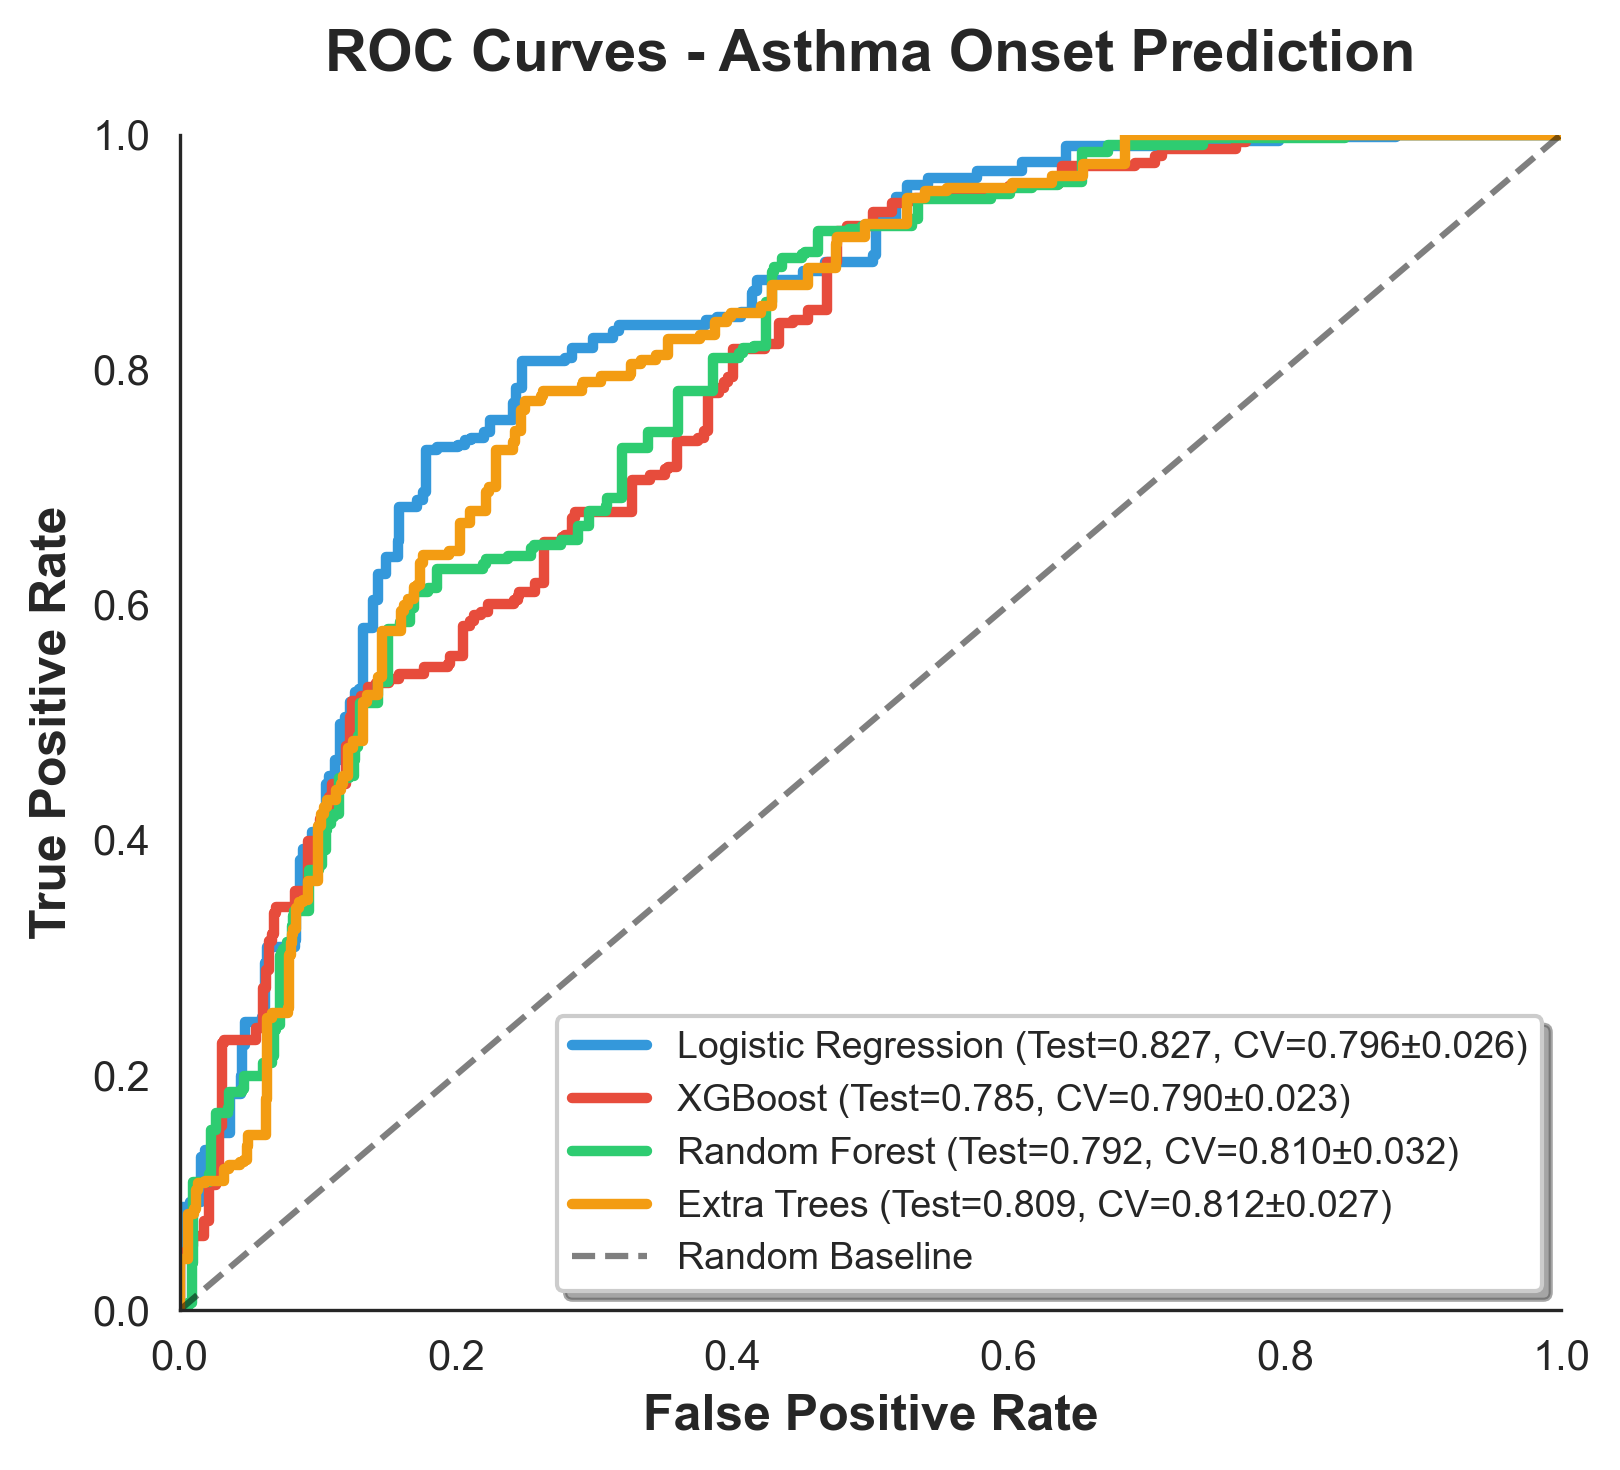

✓ ROC Curves saved: onset_roc_curves.png


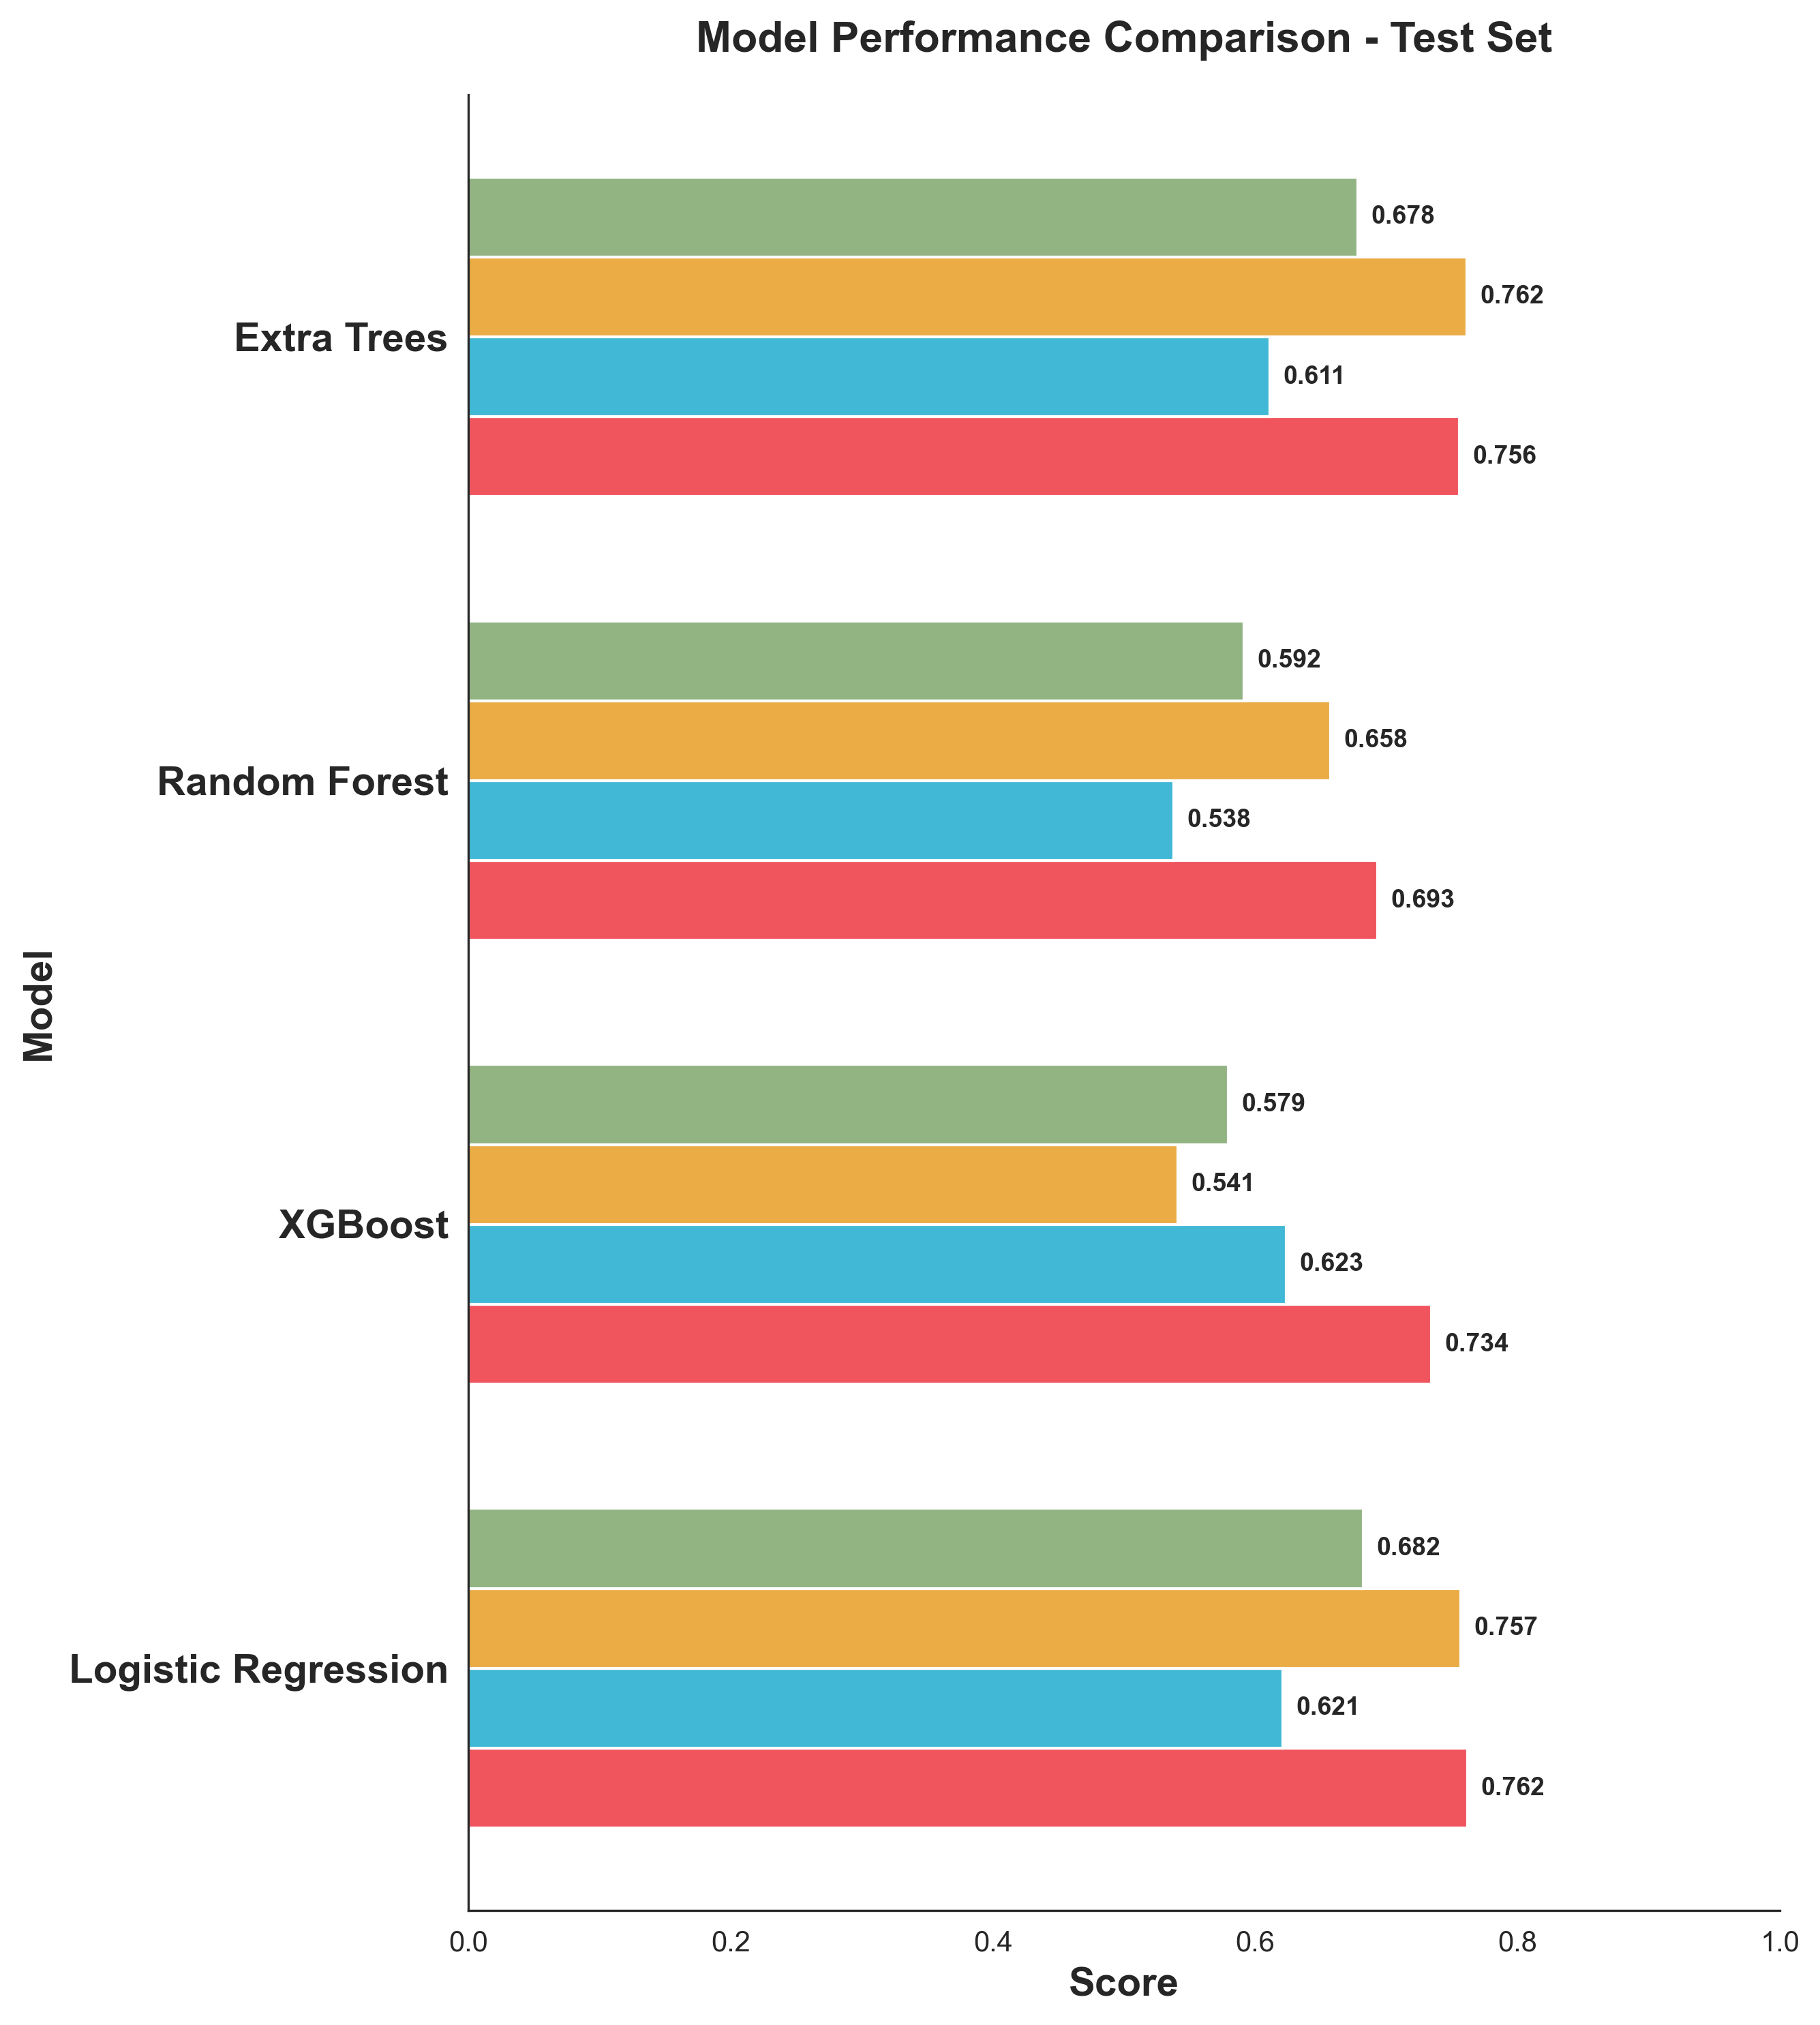

✓ All Metrics Comparison saved: onset_all_metrics.png


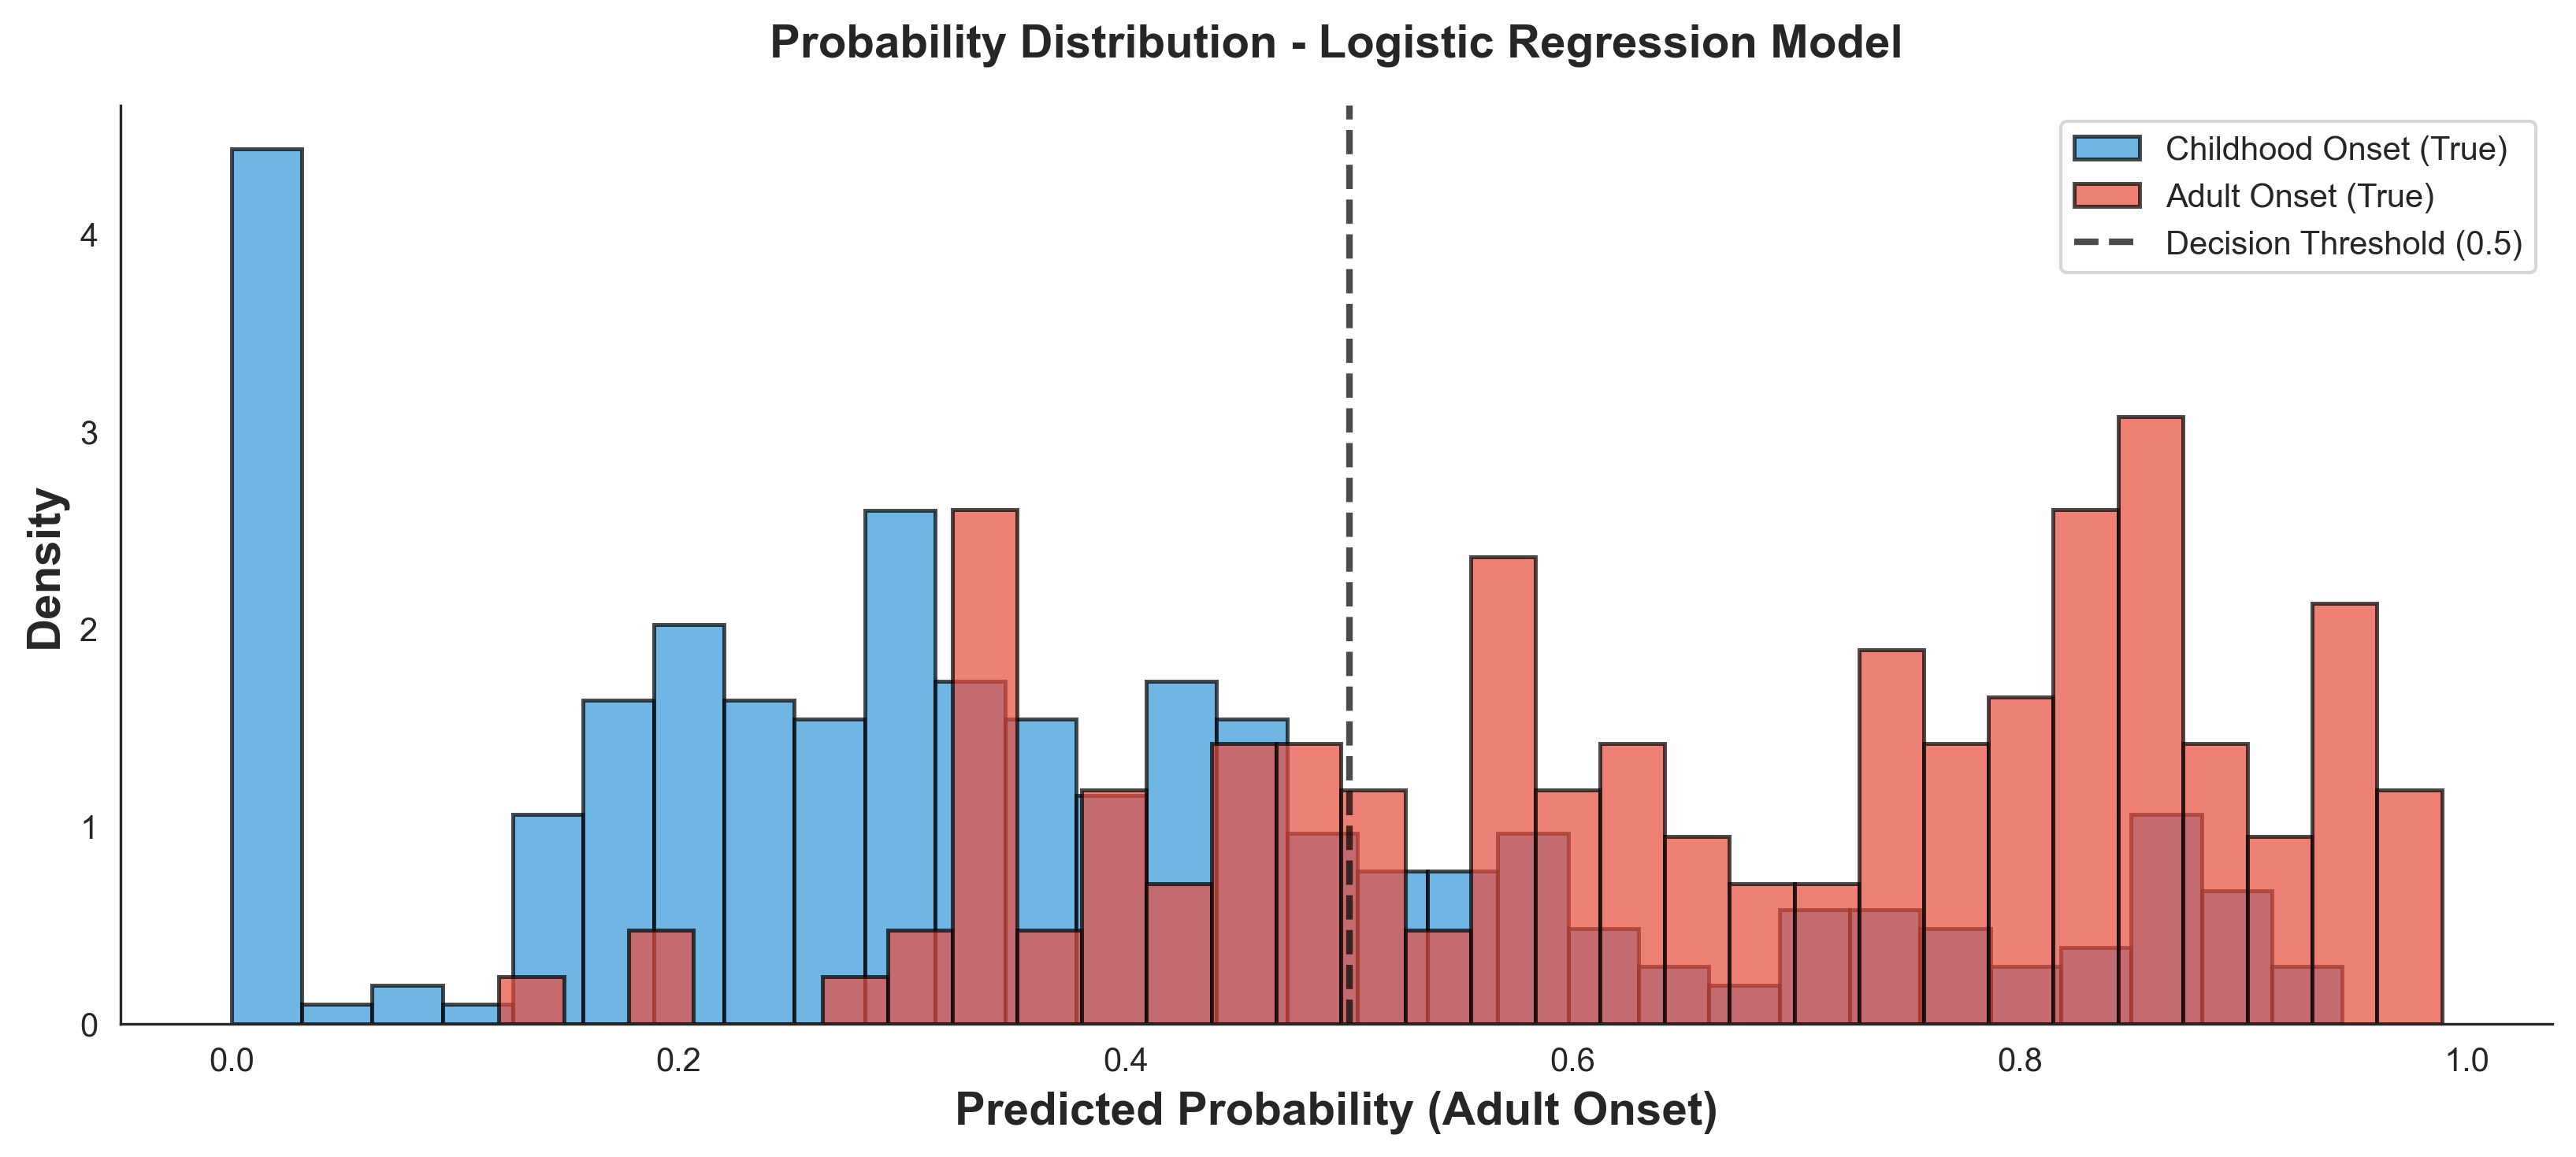

✓ Probability Distribution saved: onset_probability_distribution.png

ALL VISUALIZATIONS COMPLETED

Generated plots:
  1. onset_roc_curves.png - ROC curves with CV stats
  2. onset_precision_recall.png - Precision-Recall curves
  3. onset_all_metrics.png - All metrics in single chart
  4. onset_probability_distribution.png - Prediction distributions

All plots saved with white background at 300 DPI (NO GRIDS)

Best Model: Logistic Regression
  - CV AUC: 0.796 ± 0.026
  - Test AUC: 0.827


In [49]:
"""
COMPREHENSIVE ONSET PREDICTION VISUALIZATIONS
Clean plots with white/transparent backgrounds - NO GRIDS
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import warnings

warnings.filterwarnings('ignore')

# Set style for clean plots
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_style("white")

# ============================================================================
# LOAD DATA
# ============================================================================

# Load CV + Test results
results_df = pd.read_csv('onset_detailed_metrics_with_cv.csv')
predictions_df = pd.read_csv('onset_predictions.csv')
cv_folds_df = pd.read_csv('onset_cv_folds.csv')

y_test = predictions_df['y_true'].values
test_weights = predictions_df['test_weight'].values

# Model name mapping
model_name_mapping = {
    'LR': 'Logistic Regression',
    'XGB': 'XGBoost',
    'RF': 'Random Forest',
    'ET': 'Extra Trees'
}

# Apply full names to results_df if needed
if results_df['Model'].iloc[0] in model_name_mapping:
    results_df['Model'] = results_df['Model'].map(model_name_mapping)

# Create models dict with full names
models = {
    'Logistic Regression': predictions_df['lr_proba'].values,
    'XGBoost': predictions_df['xgb_proba'].values,
    'Random Forest': predictions_df['rf_proba'].values,
    'Extra Trees': predictions_df['et_proba'].values
}

# Color palette - use full names
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
model_colors = dict(zip(['Logistic Regression', 'XGBoost', 'Random Forest', 'Extra Trees'], colors))

# ============================================================================
# PLOT 1: AUC-ROC CURVES
# ============================================================================

fig, ax = plt.subplots(figsize=(5.5, 5))

for i, (name, proba) in enumerate(models.items()):
    fpr, tpr, _ = roc_curve(y_test, proba, sample_weight=test_weights)
    roc_auc = auc(fpr, tpr)
    
    # Get CV AUC for label
    cv_auc = results_df.loc[results_df['Model']==name, 'CV_AUC_Mean'].values[0]
    cv_std = results_df.loc[results_df['Model']==name, 'CV_AUC_Std'].values[0]
    
    ax.plot(fpr, tpr, linewidth=2.5, 
            label=f'{name} (Test={roc_auc:.3f}, CV={cv_auc:.3f}±{cv_std:.3f})',
            color=model_colors[name])

# Baseline
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Baseline')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - Asthma Onset Prediction', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower right', fontsize=9, frameon=True, fancybox=True, shadow=True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('onset_roc_curves.png', dpi=300, bbox_inches='tight', facecolor='none')
plt.show()

print("✓ ROC Curves saved: onset_roc_curves.png")

# ============================================================================
# PLOT 3: ALL METRICS IN SINGLE HORIZONTAL BAR CHART
# ============================================================================

fig, ax = plt.subplots(figsize=(9, 10))

models_list = results_df['Model'].tolist()

# Get test metrics only
accuracy = results_df['Test_Accuracy'].values
precision = results_df['Test_Precision_Adult'].values
recall = results_df['Test_Recall_Adult'].values
f1 = results_df['Test_F1_Adult'].values

# Color scheme for metrics
metric_colors = ['#f0555e', '#41b8d5', '#ebac45', '#92b382']

# Create positions for grouped bars
n_models = len(models_list)
n_metrics = 4
bar_height = 0.18
y_positions = np.arange(n_models)

# Plot each metric (no edge colors)
bars1 = ax.barh(y_positions - 1.5*bar_height, accuracy, bar_height, 
                label='Accuracy', color=metric_colors[0], alpha=1)
bars2 = ax.barh(y_positions - 0.5*bar_height, precision, bar_height, 
                label='Precision (Adult)', color=metric_colors[1], alpha=1)
bars3 = ax.barh(y_positions + 0.5*bar_height, recall, bar_height, 
                label='Recall (Adult)', color=metric_colors[2], alpha=1)
bars4 = ax.barh(y_positions + 1.5*bar_height, f1, bar_height, 
                label='F1 Score (Adult)', color=metric_colors[3], alpha=1)

# Add value labels
for i, (acc, prec, rec, f1_val) in enumerate(zip(accuracy, precision, recall, f1)):
    ax.text(acc + 0.01, i - 1.5*bar_height, f'{acc:.3f}', 
            va='center', fontsize=9, fontweight='bold')
    ax.text(prec + 0.01, i - 0.5*bar_height, f'{prec:.3f}', 
            va='center', fontsize=9, fontweight='bold')
    ax.text(rec + 0.01, i + 0.5*bar_height, f'{rec:.3f}', 
            va='center', fontsize=9, fontweight='bold')
    ax.text(f1_val + 0.01, i + 1.5*bar_height, f'{f1_val:.3f}', 
            va='center', fontsize=9, fontweight='bold')

ax.set_yticks(y_positions)
ax.set_yticklabels(models_list, fontweight='bold', fontsize=14)
ax.set_xlabel('Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Model', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Comparison - Test Set', fontsize=15, fontweight='bold', pad=15)
ax.set_xlim([0, 1])
#ax.legend(fontsize=12, frameon=True, fancybox=True, loc='upper right', ncol = 4)

# Remove only top and right spines (keep x and y axis lines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('onset_all_metrics.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ All Metrics Comparison saved: onset_all_metrics.png")

# ============================================================================
# PLOT 5: PROBABILITY DISTRIBUTION
# ============================================================================

# Get best model (based on Test AUC)
best_model_name = results_df.loc[results_df['Test_AUC'].idxmax(), 'Model']
best_proba = models[best_model_name]

fig, ax = plt.subplots(figsize=(11, 5))

# Separate probabilities by true class
childhood_proba = best_proba[y_test == 0]
adult_proba = best_proba[y_test == 1]

ax.hist(childhood_proba, bins=30, alpha=0.7, label='Childhood Onset (True)',
        color='#3498db', edgecolor='black', linewidth=1.2, density=True)
ax.hist(adult_proba, bins=30, alpha=0.7, label='Adult Onset (True)',
        color='#e74c3c', edgecolor='black', linewidth=1.2, density=True)

# Add threshold line
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, 
           label='Decision Threshold (0.5)', alpha=0.7)

ax.set_xlabel('Predicted Probability (Adult Onset)', fontsize=14, fontweight='bold')
ax.set_ylabel('Density', fontsize=14, fontweight='bold')
ax.set_title(f'Probability Distribution - {best_model_name} Model', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10, frameon=True, fancybox=True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('onset_probability_distribution.png', dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Probability Distribution saved: onset_probability_distribution.png")


# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("ALL VISUALIZATIONS COMPLETED")
print("="*60)
print("\nGenerated plots:")
print("  1. onset_roc_curves.png - ROC curves with CV stats")
print("  2. onset_precision_recall.png - Precision-Recall curves")
print("  3. onset_all_metrics.png - All metrics in single chart")
print("  4. onset_probability_distribution.png - Prediction distributions")
print("\nAll plots saved with white background at 300 DPI (NO GRIDS)")
print(f"\nBest Model: {best_model_name}")
print(f"  - CV AUC: {results_df.loc[results_df['Model']==best_model_name, 'CV_AUC_Mean'].values[0]:.3f} ± {results_df.loc[results_df['Model']==best_model_name, 'CV_AUC_Std'].values[0]:.3f}")
print(f"  - Test AUC: {results_df.loc[results_df['Model']==best_model_name, 'Test_AUC'].values[0]:.3f}")
print("="*60)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Dataset distribution:
  Childhood onset (<18): 330 (69.3%)
  Adult onset (≥18): 146 (30.7%)
  Ratio (Childhood:Adult): 2.26:1

Training set:
  Childhood: 1328 (69.7%)
  Adult: 576 (30.3%)
  Ratio (Childhood:Adult): 2.31:1

Computing SHAP values for 476 samples...
SHAP values computed: (476, 22)

Created SHAP dataframe with 22 features


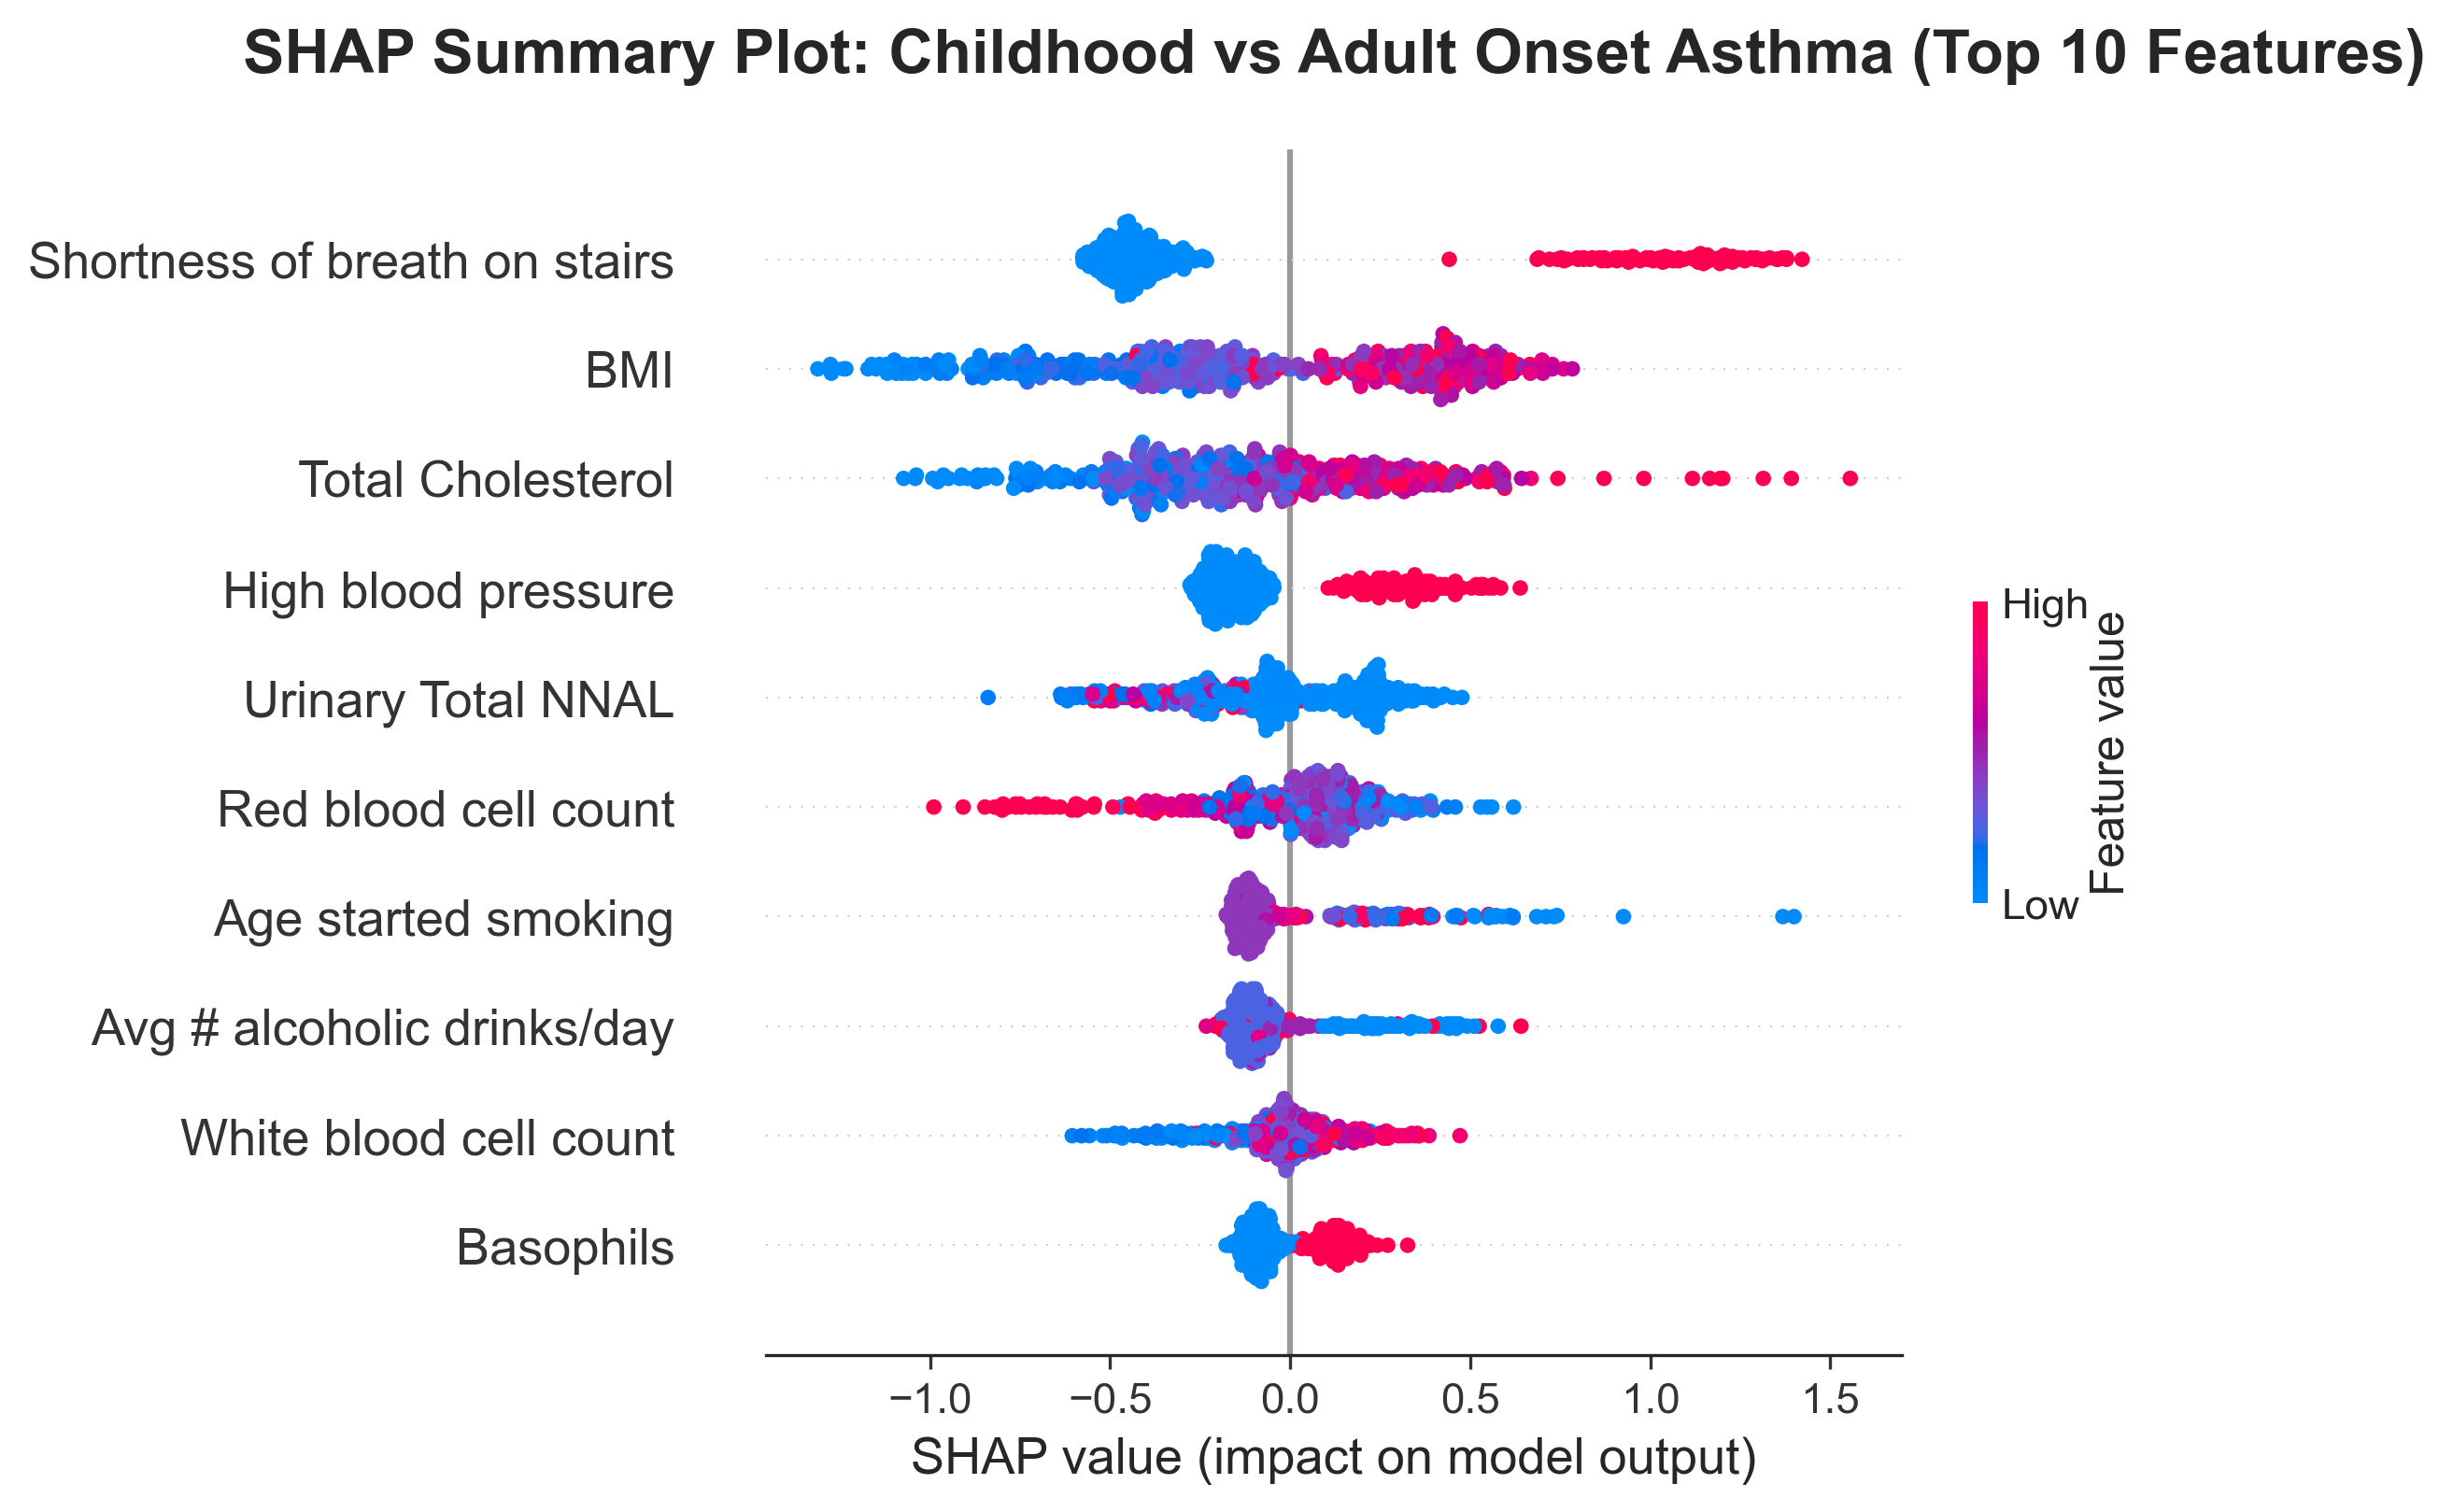


Visualization saved: shap_summary.png


ValueError: 'lower' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

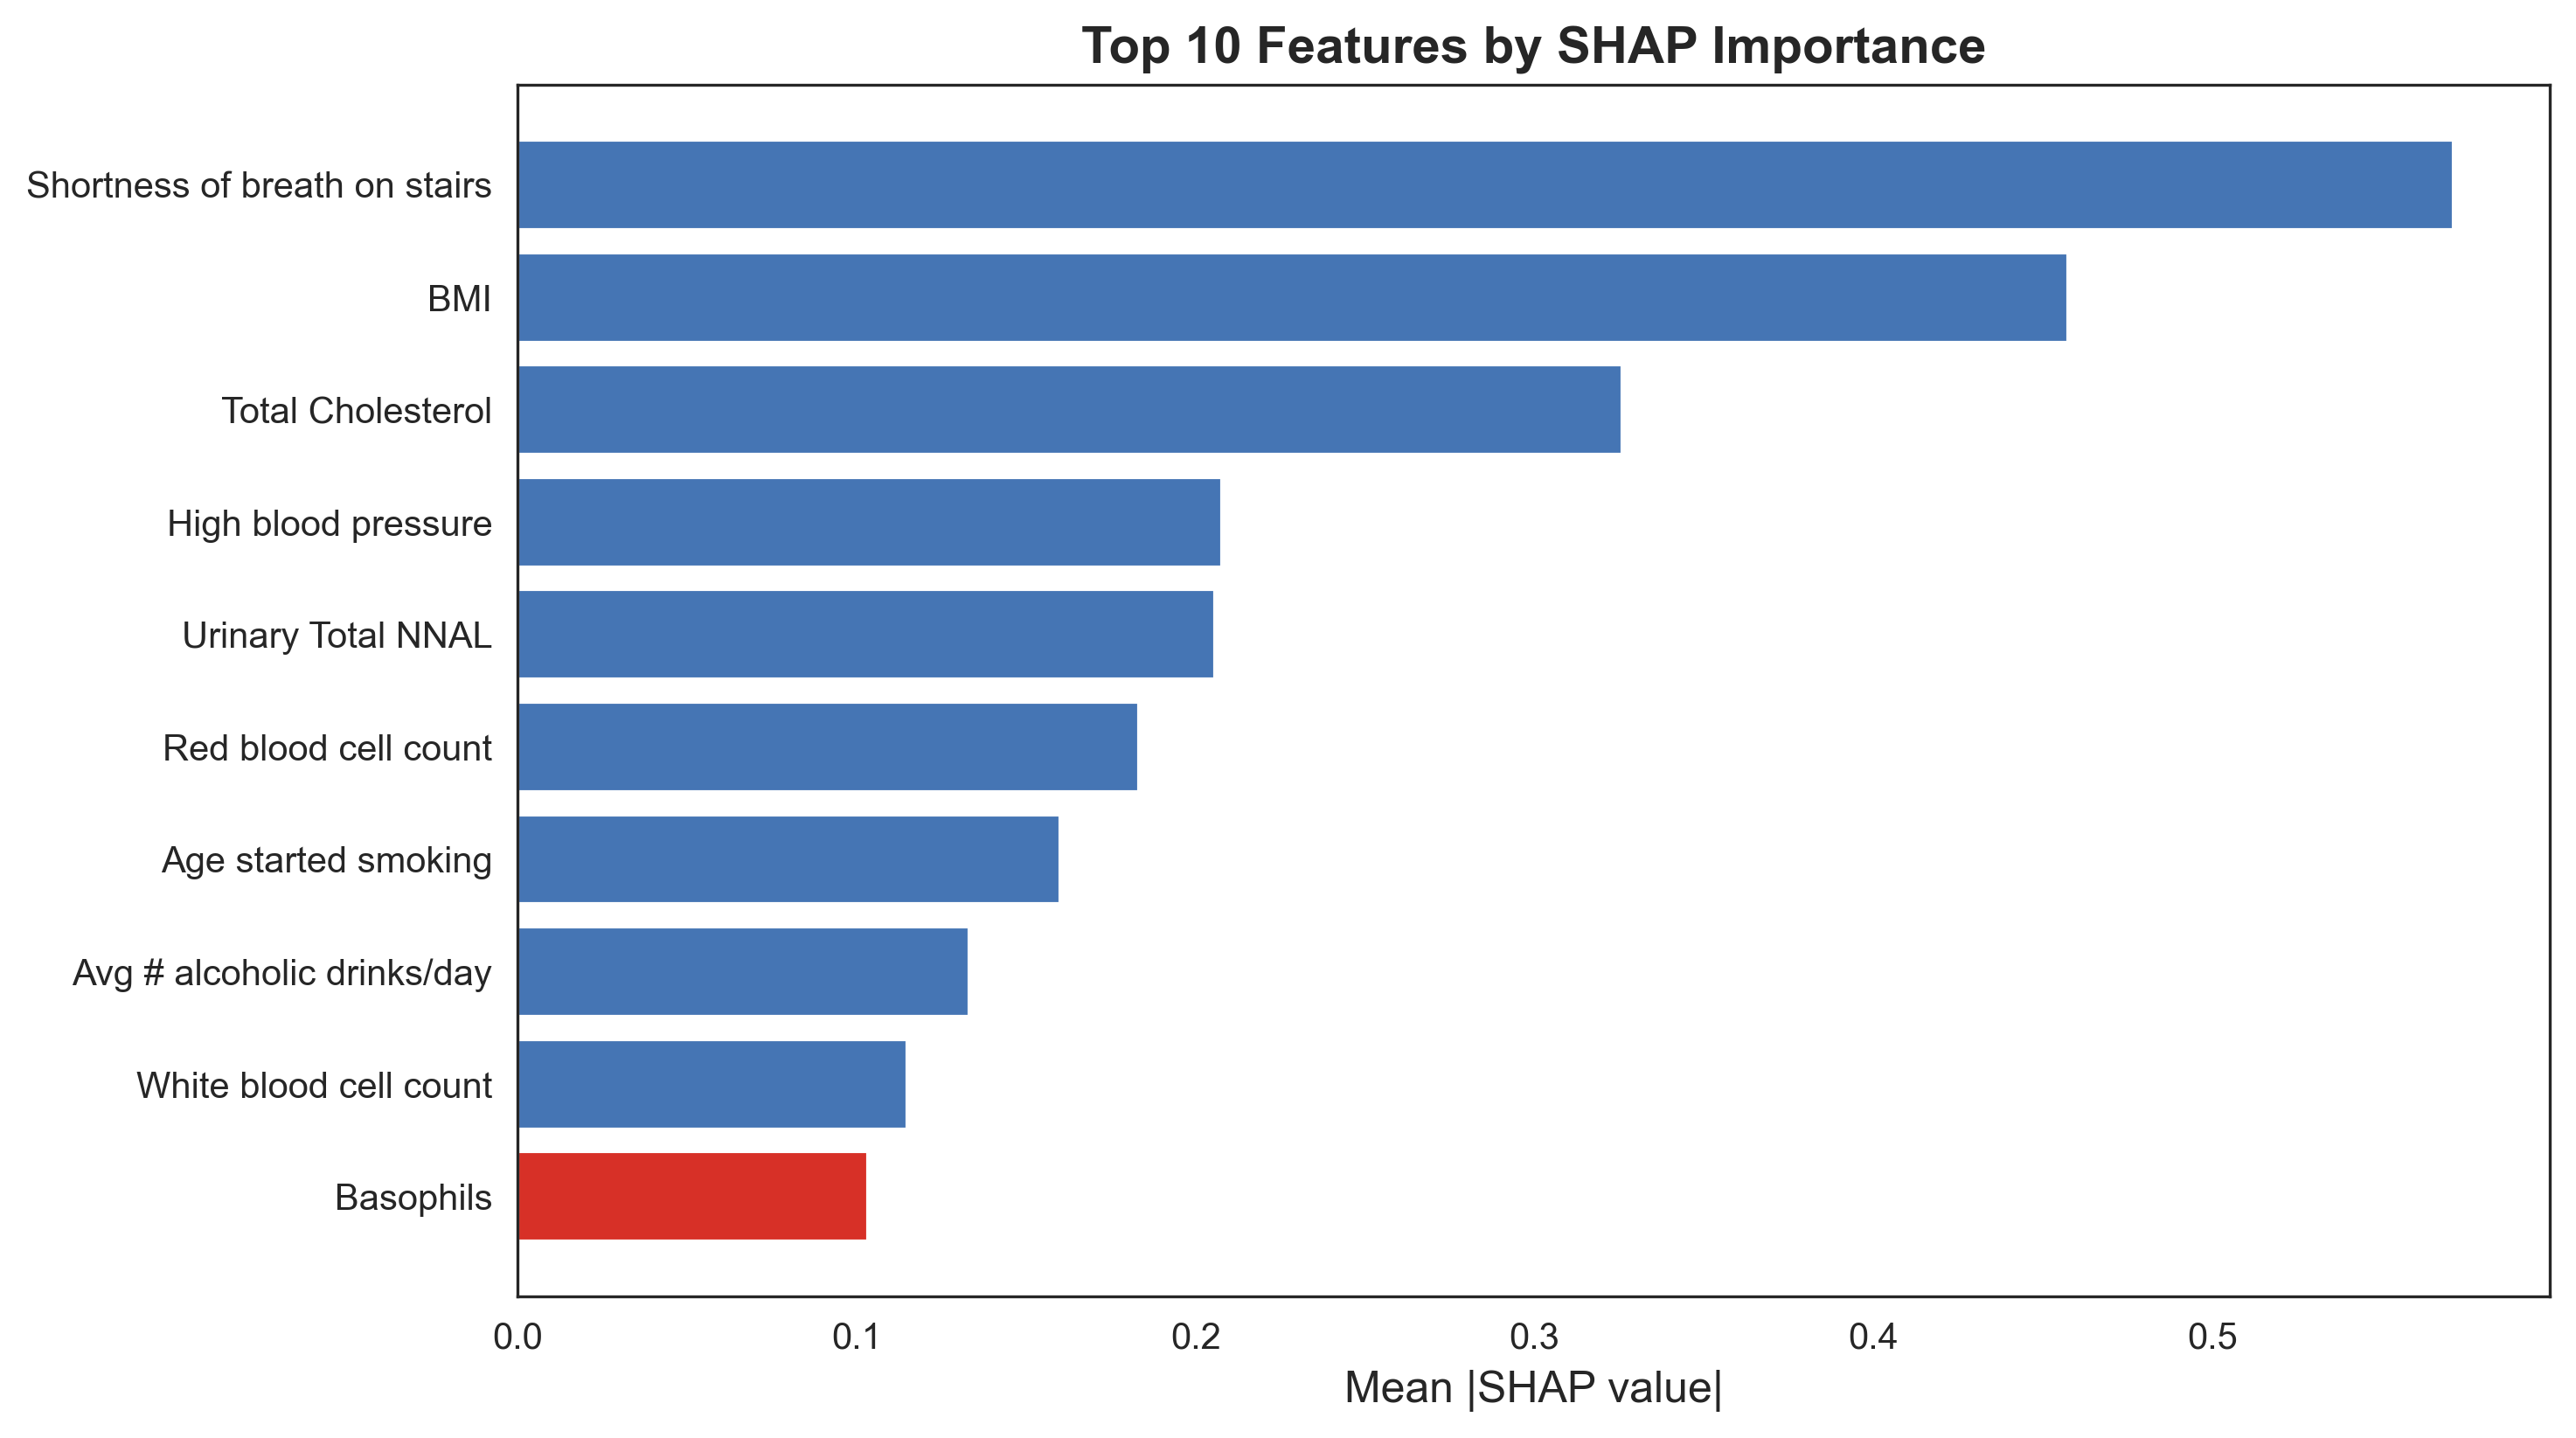

In [53]:
# ============================================================
# SHAP ANALYSIS: CHILDHOOD vs ADULT ASTHMA ONSET
# =============================================================
#!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
import json

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# ============================================================================
# LOAD MODEL AND DATA
# ============================================================================

xgb_model = joblib.load('onset_xgb_model.pkl')
X_test = pd.read_csv('X_test_onset.csv')
y_test = pd.read_csv('y_test_onset.csv').values.ravel()
predictions = pd.read_csv('onset_predictions.csv')

# Check class distribution
childhood_count = (y_test == 0).sum()
adult_count = (y_test == 1).sum()
total_count = len(y_test)

print(f"Dataset distribution:")
print(f"  Childhood onset (<18): {childhood_count} ({childhood_count/total_count*100:.1f}%)")
print(f"  Adult onset (≥18): {adult_count} ({adult_count/total_count*100:.1f}%)")
print(f"  Ratio (Childhood:Adult): {childhood_count/adult_count:.2f}:1")

# Also check training set
y_train = pd.read_csv('y_train_onset.csv').values.ravel()
train_childhood = (y_train == 0).sum()
train_adult = (y_train == 1).sum()
print(f"\nTraining set:")
print(f"  Childhood: {train_childhood} ({train_childhood/len(y_train)*100:.1f}%)")
print(f"  Adult: {train_adult} ({train_adult/len(y_train)*100:.1f}%)")
print(f"  Ratio (Childhood:Adult): {train_childhood/train_adult:.2f}:1")

# ============================================================================
# COMPUTE SHAP VALUES
# ============================================================================

print(f"\nComputing SHAP values for {X_test.shape[0]} samples...")

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

print(f"SHAP values computed: {shap_values.shape}")

# ============================================================================
# CREATE SHAP DATAFRAME FOR ANALYSIS
# ============================================================================

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
mean_shap = shap_values.mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Abs_SHAP': mean_abs_shap,
    'Mean_SHAP': mean_shap
})

print(f"\nCreated SHAP dataframe with {len(shap_df)} features")

# ============================================================================
# FIGURE: SHAP SUMMARY PLOT (TOP 10 FEATURES)
# ============================================================================

# Create SHAP summary plot (dot plot) with top 10 features
plt.figure(figsize=(10, 7))

shap.summary_plot(
    shap_values,
    X_test,
    max_display=10,
    plot_type="dot",
    show=False,
    color_bar_label="Feature value"
)

# Get current colorbar and resize it
cbar = plt.gcf().axes[-1]  # Get the colorbar axes
cbar.set_aspect(20)  # Make it narrower (higher number = narrower)

plt.title(
    "SHAP Summary Plot: Childhood vs Adult Onset Asthma (Top 10 Features)",
    fontsize=16,
    fontweight='bold',
    pad=20
)

plt.tight_layout()
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("\nVisualization saved: shap_summary.png")

# ============================================================================
# ADDITIONAL VISUALIZATION: BAR PLOT OF TOP FEATURES
# ============================================================================

plt.figure(figsize=(10, 6))

top_features = shap_df.nlargest(10, 'Mean_Abs_SHAP')
colors = ['#d73027' if x > 0 else '#4575b4' for x in top_features['Mean_SHAP']]

plt.barh(range(len(top_features)), top_features['Mean_Abs_SHAP'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.title('Top 10 Features by SHAP Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d73027', label='→ Adult Onset'),
    Patch(facecolor='#4575b4', label='→ Childhood Onset')
]
plt.legend(handles=legend_elements, loc='lower')

plt.tight_layout()
plt.savefig("shap_feature_importance_bar.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("Visualization saved: shap_feature_importance_bar.png")

# ============================================================================
# SAVE INTERPRETATION DATA
# ============================================================================

# Sort by absolute importance for export
interpretation_df = shap_df.sort_values('Mean_Abs_SHAP', ascending=False)
interpretation_df.to_csv('shap_feature_interpretation.csv', index=False)

# Identify strong predictors
childhood_predictors = interpretation_df[interpretation_df['Mean_SHAP'] < -0.01].head(10)
adult_predictors = interpretation_df[interpretation_df['Mean_SHAP'] > 0.01].head(10)

# Save detailed interpretation
with open('shap_interpretation.txt', 'w') as f:
    f.write("SHAP FEATURE INTERPRETATION\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Dataset Distribution:\n")
    f.write(f"  Test - Childhood: {childhood_count} ({childhood_count/total_count*100:.1f}%)\n")
    f.write(f"  Test - Adult: {adult_count} ({adult_count/total_count*100:.1f}%)\n")
    f.write(f"  Ratio: {childhood_count/adult_count:.2f}:1 (Childhood:Adult)\n\n")
    
    f.write("="*80 + "\n")
    f.write("Top 10 Features by Importance:\n\n")
    for i, row in interpretation_df.head(10).iterrows():
        direction = "→ ADULT" if row['Mean_SHAP'] > 0.01 else "→ CHILDHOOD" if row['Mean_SHAP'] < -0.01 else "→ NEUTRAL"
        f.write(f"{row['Feature']:<50} {direction:<15} SHAP={row['Mean_SHAP']:+.4f}\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("CHILDHOOD ONSET Predictors (SHAP < -0.01):\n")
    if len(childhood_predictors) > 0:
        for i, row in childhood_predictors.iterrows():
            f.write(f"  • {row['Feature']}: {row['Mean_SHAP']:.4f}\n")
    else:
        f.write("  • No strong individual predictors found\n")
    
    f.write("\nADULT ONSET Predictors (SHAP > 0.01):\n")
    if len(adult_predictors) > 0:
        for i, row in adult_predictors.iterrows():
            f.write(f"  • {row['Feature']}: {row['Mean_SHAP']:.4f}\n")
    else:
        f.write("  • No strong individual predictors found\n")

print("\nFile saved: shap_interpretation.txt")

# Save summary stats
summary_stats = {
    'test_samples': int(total_count),
    'childhood_count': int(childhood_count),
    'adult_count': int(adult_count),
    'childhood_percent': float(childhood_count/total_count*100),
    'adult_percent': float(adult_count/total_count*100),
    'childhood_to_adult_ratio': float(childhood_count/adult_count),
    'train_childhood': int(train_childhood),
    'train_adult': int(train_adult),
    'base_value': float(explainer.expected_value),
    'mean_prediction': float(predictions['xgb_proba'].mean()),
    'top_childhood_features': childhood_predictors['Feature'].tolist()[:5] if len(childhood_predictors) > 0 else [],
    'top_childhood_shap': [float(x) for x in childhood_predictors['Mean_SHAP'].tolist()[:5]] if len(childhood_predictors) > 0 else [],
    'top_adult_features': adult_predictors['Feature'].tolist()[:5] if len(adult_predictors) > 0 else [],
    'top_adult_shap': [float(x) for x in adult_predictors['Mean_SHAP'].tolist()[:5]] if len(adult_predictors) > 0 else []
}

with open('shap_summary_stats.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("File saved: shap_summary_stats.json")

# ============================================================================
# PRINT TOP FINDINGS
# ============================================================================

print("\n" + "="*80)
print("TOP FINDINGS")
print("="*80)

print(f"\nTop 5 Features Predicting CHILDHOOD Onset (negative SHAP):")
for i, row in childhood_predictors.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Mean_SHAP']:.4f}")

print(f"\nTop 5 Features Predicting ADULT Onset (positive SHAP):")
for i, row in adult_predictors.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Mean_SHAP']:.4f}")

print("\n" + "="*80)
print("FILES SAVED:")
print("="*80)
print("  - shap_summary.png (SHAP dot plot - Top 10)")
print("  - shap_feature_importance_bar.png (bar chart - Top 10)")
print("  - shap_feature_interpretation.csv (all features with SHAP values)")
print("  - shap_interpretation.txt (detailed text report)")
print("  - shap_summary_stats.json (summary statistics)")
print("\nSHAP analysis complete!")